In [2]:
"""
*Filename: SecondaryVertexDeepSetTrainer
*Description: This jupyter notebook is an extension of the ProjectorTrainer, it trains the same
*residual deep sets neural network architecture as the projector trainer with the additional
*features as well. In addition it adds the secondary vertex displacement of the b_jets as an
*additional target for the network to converge to.
Date: 16/02/2023
Author: Kaylen Smith Darnbrook
"""
# Import relevant modules
import os
import numpy as np
import seaborn as sns
import wandb
#from wandb.keras import WandbCallback
from keras import callbacks
import keras
import DeepSetNeuralNetArchitecture2 as DSNNA
from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from DeepSetNeuralNetArchitecture import Mean_Squared_Error
from HffragDeepSetsProjectionMultivariate import DeepSetsProjection
from sklearn.feature_selection import mutual_info_regression
import keras.backend as k
import uproot
import awkward as ak
import sklearn as sk
from numpy.lib.recfunctions import structured_to_unstructured
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import pandas as pd
from hffrag import fixedbinning
from hffrag import binneddensity
from keras.utils.vis_utils import plot_model
from timeit import default_timer as timer
import matplotlib.pyplot as plt
%matplotlib inline

number of jets to train on:
141329


/home/physics/phujdj/DeepLearningParticlePhysics/hffrag.py:136: RuntimeWarning: overflow encountered in sinh
  pzs = numpy.where(mask, pts, pts * numpy.sinh(etas))


In [3]:
#Format the style and format of the matplotlib plots
plt.style.use("default")
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rc('text',usetex = False)
plt.rc('font',family = 'Times New Roman')

In [ ]:
# The data is being stored in a tree datastructure.
# We access the charm root using this command
tree = uproot.open("/storage/epp2/phswmv/data/hffrag/hffrag.root:CharmAnalysis")

In [4]:
# Initial parameters
MASKVAL = -999 # This value is introduced to ensure arrays are regular (Of the same size). They will be masked later by the network
MAXTRACKS = 32 # This value is the maximum number of tracks allowed per event
BATCHSIZE = 64 # This is the batch size of the mini batches used during training
EPOCHS = 1000  # This is the default number of epochs for which the neural network will train providing that early stopping does not occur
MAXEVENTS = 3e6 #This is the maximum number of events that will the program will accept
LR = 3e-4 #This is the default learning rate

In [ ]:
# Select the features we wish to study
track_features = ["AnalysisTracks_pt", "AnalysisTracks_eta", "AnalysisTracks_phi", "AnalysisTracks_z0sinTheta",
                   "AnalysisTracks_d0sig", "AnalysisTracks_d0", "AnalysisTracks_d0sigPV", "AnalysisTracks_d0PV"]
jet_features = ["AnalysisAntiKt4TruthJets_pt", "AnalysisAntiKt4TruthJets_eta", "AnalysisAntiKt4TruthJets_phi", "AnalysisAntiKt4TruthJets_m","AnalysisAntiKt4TruthJets_ghostB_pdgId",
                "AnalysisAntiKt4TruthJets_ghostB_pt", "AnalysisAntiKt4TruthJets_ghostB_eta","AnalysisAntiKt4TruthJets_ghostB_phi", "AnalysisAntiKt4TruthJets_ghostB_m"]
Electrons_features = ["AnalysisElectrons_pt_NOSYS","AnalysisElectrons_eta", "AnalysisElectrons_phi", "AnalysisElectrons_z0sinTheta", 
                    "AnalysisElectrons_d0sig", "AnalysisElectrons_d0", "AnalysisElectrons_d0sigPV", "AnalysisElectrons_d0PV"]
reconstructed_jet_features = ["AnalysisJets_pt_NOSYS", "AnalysisJets_eta", "AnalysisJets_phi", "AnalysisJets_m"]
Muon_Features = ["AnalysisMuons_pt_NOSYS", "AnalysisMuons_eta", "AnalysisMuons_phi","AnalysisMuons_z0sinTheta", 
                    "AnalysisMuons_d0sig", "AnalysisMuons_d0", "AnalysisMuons_d0sigPV", "AnalysisMuons_d0PV"]

In [ ]:
# Read in the data from the root file
features = tree.arrays(jet_features+track_features + Electrons_features + Muon_Features + reconstructed_jet_features, entry_stop=MAXEVENTS)

In [ ]:
# Select the events of interest
goodjets = \
  np.logical_and \
    ( np.abs(features["AnalysisAntiKt4TruthJets_eta"]) < 2.5
    , features["AnalysisAntiKt4TruthJets_pt"] > 25000
    )

events = features[(ak.sum(goodjets, axis=1) > 0)]

In [ ]:
# Displays the number of jets being trained on
jets = events[jet_features][:,0]
print("The number of jets to train on is: ", len(jets))
print("The number of track features is: ",len(track_features))

The number of jets to train on is:  2670822
The number of track features is:  8


In [ ]:
# Select tracks from the events
tracks = events[track_features]
electrons = events[Electrons_features]
muons = events[Muon_Features]
rejets = events[reconstructed_jet_features]

#Match the particles to the reconstructed information
mask_rejets = DSNNA.Match_Reconstructed(jets, rejets)
mask_tracks = DSNNA.Match_Tracks(jets, tracks)
mask_electrons = DSNNA.Match_Electrons(jets,electrons)
mask_muons = DSNNA.Match_Muons(jets,muons)
matchedtracks = tracks[mask_tracks]
matchedelectrons = electrons[mask_electrons]
matchedmuons = muons[mask_muons]

# Pad and Flatten the data
rejets = rejets[mask_rejets]
matchedtracks = DSNNA.flatten(matchedtracks, MAXTRACKS)
matchedelectrons = DSNNA.flatten(matchedelectrons, MAXTRACKS)
matchedmuons = DSNNA.flatten(matchedmuons, MAXTRACKS)

In [ ]:
#Selects the b-jets with bhadrons with a transverse momentum over 5000 MeV
bjets = ak.sum(jets["AnalysisAntiKt4TruthJets_ghostB_pt"] > 5000, axis=1) > 0
jets = jets[bjets]
rejets = rejets[bjets]
rejets = DSNNA.pad(rejets,MAXTRACKS)[:,0]

# Obtain the pt, eta and phi of each b hadron jet
bhads_pt = jets["AnalysisAntiKt4TruthJets_ghostB_pt"][:, 0].to_numpy()
bhads_eta = jets["AnalysisAntiKt4TruthJets_ghostB_eta"][:,0].to_numpy()
bhads_phi = jets["AnalysisAntiKt4TruthJets_ghostB_phi"][:,0].to_numpy()
bhads_m = jets["AnalysisAntiKt4TruthJets_ghostB_m"][:,0].to_numpy()
bhads_PGID = jets["AnalysisAntiKt4TruthJets_ghostB_pdgId"][:,0].to_numpy()

jets_pt = jets["AnalysisAntiKt4TruthJets_pt"].to_numpy()
jets_eta = jets["AnalysisAntiKt4TruthJets_eta"].to_numpy()
jets_phi = jets["AnalysisAntiKt4TruthJets_phi"].to_numpy()
jets_m = jets["AnalysisAntiKt4TruthJets_m"].to_numpy()
b_jets = np.stack([jets_pt,jets_eta,jets_phi, jets_m], axis = -1)

rejets_pt = rejets["AnalysisJets_pt_NOSYS"].to_numpy()
rejets_eta = rejets["AnalysisJets_eta"].to_numpy()
rejets_phi = rejets["AnalysisJets_phi"].to_numpy()
rejets_m = rejets["AnalysisJets_m"].to_numpy()
re_b_jets = np.stack([rejets_pt,rejets_eta,rejets_phi, rejets_m], axis = -1)

bhads = np.stack([bhads_pt,bhads_eta,bhads_phi, bhads_m],axis = -1) #Combine the momentum, eta and phi for each jet into one array

print("There are {} outputs".format(np.shape(bhads)[1])) # Display the number of target features the neural network will predict
matchedtracks = matchedtracks[bjets]
matchedelectrons = matchedelectrons[bjets]
matchedmuons = matchedmuons[bjets]
print("There are {} tracks inputs".format(np.shape(matchedtracks)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} electrons inputs".format(np.shape(matchedelectrons)[1])) # Display the number of target features the neural network will use in it's predictions
print("There are {} muons inputs".format(np.shape(matchedmuons)[1])) # Display the number of target features the neural network will use in it's predictions

There are 4 outputs
There are 32 tracks inputs
There are 32 electrons inputs
There are 32 muons inputs


In [ ]:
# Transform the jet and tracks to unstructed data.
rejets = rejets.to_numpy()
rejets = structured_to_unstructured(rejets[reconstructed_jet_features])
jets = structured_to_unstructured(jets[jet_features[:-5]])
matchedtracks = structured_to_unstructured(matchedtracks)
matchedelectrons  = structured_to_unstructured(matchedelectrons)
matchedmuons = structured_to_unstructured(matchedmuons)

In [ ]:
# Convert the coordinates of the b jets and tracks to cartesian coordinates
polartracks = matchedtracks.to_numpy()
polarelectrons = matchedelectrons.to_numpy()
polarmuons = matchedmuons.to_numpy()

Num_events = MAXTRACKS
tracks_pt = polartracks[:,:,0].reshape(-1,Num_events,1)
tracks_eta = polartracks[:,:,1].reshape(-1,Num_events,1)
tracks_phi = polartracks[:,:,2].reshape(-1,Num_events,1)

tracks_pep = np.concatenate([tracks_pt,tracks_eta,tracks_phi], axis = -1) 
print(tracks_pep.shape)

electrons_pt = polarelectrons[:,:,0].reshape(-1,Num_events,1)
electrons_eta = polarelectrons[:,:,1].reshape(-1,Num_events,1)
electrons_phi = polarelectrons[:,:,2].reshape(-1,Num_events,1)

electrons_pep = np.concatenate([electrons_pt,electrons_eta,electrons_phi], axis = -1) 
print(electrons_pep.shape)

muons_pt = polarmuons[:,:,0].reshape(-1,Num_events,1)
muons_eta = polarmuons[:,:,1].reshape(-1,Num_events,1)
muons_phi = polarmuons[:,:,2].reshape(-1,Num_events,1)

muons_pep = np.concatenate([muons_pt,muons_eta,muons_phi], axis = -1) 
print(muons_pep.shape)

jets_pt = b_jets[:,0].reshape(-1,1)
jets_eta = b_jets[:,1].reshape(-1,1)
jets_phi = b_jets[:,2].reshape(-1,1)

rejets_pt = re_b_jets[:,0].reshape(-1,1)
rejets_eta = re_b_jets[:,1].reshape(-1,1)
rejets_phi = re_b_jets[:,2].reshape(-1,1)

re_b_jets_pep = np.concatenate([rejets_pt,rejets_eta,rejets_phi], axis = -1) 
print(re_b_jets_pep.shape)

reconjet_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(re_b_jets)
re_b_jets_m = re_b_jets[:,-1].reshape(-1,1)
re_b_jets = np.concatenate([reconjet_p,re_b_jets_pep,re_b_jets_m], axis = -1)

b_jets_pep = np.concatenate([jets_pt,jets_eta,jets_phi], axis = -1) 
print(b_jets_pep.shape)

tracks_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedtracks.to_numpy())
electrons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedelectrons.to_numpy())
muons_p = DSNNA.pt_eta_phi_2_px_py_pz_tracks(matchedmuons.to_numpy())

bhads = DSNNA.pt_eta_phi_2_px_py_pz_jets(bhads)
b_jets_p = DSNNA.pt_eta_phi_2_px_py_pz_jets(b_jets)
b_jets_m = b_jets[:,-1].reshape(-1,1)

#Combine the momenta of the tracks with the rest of the track features to form the track dataset
tracks = np.concatenate([tracks_p,tracks_pep,matchedtracks[:,:,3:].to_numpy()],axis = 2)
electrons = np.concatenate([electrons_p, electrons_pep, matchedelectrons[:,:,3:].to_numpy()], axis = 2)
muons = np.concatenate([muons_p, muons_pep, matchedmuons[:,:,3:].to_numpy()], axis = 2)

print(np.shape(tracks), np.shape(electrons), np.shape(muons))
particles = np.concatenate([tracks,electrons,muons], axis = 1)
b_jets = np.concatenate([b_jets_p,b_jets_pep,b_jets_m] ,axis = 1)

(1287909, 32, 3)
(1287909, 32, 3)
(1287909, 32, 3)
(1287909, 3)
(1287909, 3)


/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetNeuralNetArchitecture2.py:163: RuntimeWarning: overflow encountered in sinh
  pzs = np.where(mask1 | mask3, pts, pts * np.sinh(etas))


(1287909, 32, 11) (1287909, 32, 11) (1287909, 32, 11)


In [ ]:
#Mask out the MASKVALs used to pad the arrays
particles = np.ma.masked_values(particles,-999)
#Mask out the MASKVALs used to pad the reconstructed jets
re_b_jets = np.ma.masked_values(re_b_jets,-999)

In [ ]:
#Calculate the fraction of the momenta that
# the bhadrons represent of the b_jet momenta
bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
print(bhads_fractions_px.shape)

(1287909,)


In [84]:
# Calculate the magnitude of the b_jets momenta and 
# use it to calculate the projection of the bhadron momenta along the 
# b_jet momenta
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_fractions = np.stack([bhads_fractions_px,bhads_fractions_py, bhads_fractions_pz], axis = -1)
bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(bhads_fractions.shape)

(1287909, 3)


In [85]:
#Creates an approximate track momentum and 4 momentum for the network to use.
particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)
particles_4_Momentum = np.stack([particles_Momentum, particles[:,:,0], particles[:,:,1], particles[:,:,2]], axis = -1)
print(particles_4_Momentum.shape)

/tmp/ipykernel_24431/4078472412.py:2: RuntimeWarning: invalid value encountered in sqrt
  particles_Momentum = np.sqrt(particles[:, : ,0]**2 + particles[:,:,1]**2 + particles[:,:,2]**2)


(1287909, 96, 4)


In [86]:
#Creates a very approximate track mass for the network to use.
particles_Invariant_Mass = np.sqrt((np.sum(particles_4_Momentum, axis = 1) * np.sum(particles_4_Momentum, axis = 1)).sum(axis = -1))
print(particles_Invariant_Mass.shape)

(1287909,)


In [87]:
#From the base features for the tracks and jet provided by the roots 
#file calculate the derived features needed for convergence.
#These features were inspired from reading on current particle physics literature
b_jets_mag = np.linalg.norm(b_jets[:,:3], axis = 1)
bhads_mag = np.linalg.norm(bhads[:,:3], axis = 1)
re_b_jets_mag = np.linalg.norm(re_b_jets[:,:3], axis = 1)
particles_Momentum = np.sum(np.linalg.norm(particles[:,:,:3], axis = 2))

bhads_fractions_px = bhads[:,0]/b_jets[:,0]
bhads_fractions_py = bhads[:,1]/b_jets[:,1]
bhads_fractions_pz = bhads[:,2]/b_jets[:,2]
bhads_fractions_pt = bhads_pt/b_jets_pep[:,0]
print(bhads_fractions_px.shape)

ConeRadius = np.sqrt((particles[:,:,4] - re_b_jets_pep[:,np.newaxis,1])**2 + (particles[:,:,5] - re_b_jets_pep[:,np.newaxis,2])**2)
LogConeRadius = np.log(ConeRadius)

b_jets_energy = np.sqrt((b_jets_m[:,0]**2) + (b_jets_mag**2))
print(b_jets_energy.shape, b_jets_m.shape)

b_jets_energy_pt = np.sqrt((b_jets_m[:,0]**2) + (b_jets[:,4]**2))
b_jets_energy_pt.shape

re_b_jets_energy_pt = np.sqrt((re_b_jets[:,0]**2) + (re_b_jets_m[:,0]**2))
re_b_jets_energy_pt.shape

re_b_jets_energy = np.sqrt((re_b_jets_m[:,0]**2) + (re_b_jets_mag**2))
print(re_b_jets_energy.shape)

b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]
b_jet_energy_mass_ratio[np.isinf(b_jet_energy_mass_ratio)] = np.median(b_jet_energy_mass_ratio)

re_b_jet_energy_mass_ratio = re_b_jets_energy/re_b_jets_m[:,0]
re_b_jet_energy_mass_ratio[np.isinf(re_b_jet_energy_mass_ratio)] = np.median(re_b_jet_energy_mass_ratio)

print(b_jet_energy_mass_ratio.shape)
bhads_energy = np.sqrt((bhads_m**2) + (bhads_mag**2))
bhads_energy.shape

bhads_energy_mass_ratio = bhads_energy/bhads_m

print(bhads_fractions[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions),np.max(bhads_fractions))

print(bhads_fractions_px[0])
print(bhads[0,0]/b_jets[0,0])
print(np.min(bhads_fractions_px),np.max(bhads_fractions_px))

print("Hello")
sum_px_particles = np.sum(particles[:,:,0], axis = 1)
sum_py_particles = np.sum(particles[:,:,1], axis = 1)
sum_pz_particles = np.sum(particles[:,:,2], axis = 1)
sum_pt_particles = np.sum(particles[:,:,3], axis = 1)
print(sum_pt_particles.shape)

sum_eta_particles = np.sum(particles[:,:,4], axis = 1)
sum_phi_particles = np.sum(particles[:,:,5], axis = 1)
sum_z0sin_particles = np.sum(particles[:,:,6], axis = 1)
sum_d0sig_particles = np.sum(particles[:,:,7], axis = 1)

sum_d0_particles = np.sum(particles[:,:,8], axis = 1)
sum_d0sigPV_particles = np.sum(particles[:,:,9], axis = 1)
sum_d0PV_particles = np.sum(particles[:,:,10], axis = 1)

sum_px_particles_RSE = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1))
sum_py_particles_RSE= np.sqrt(np.sum(particles[:,:,1]**2, axis = 1))
sum_pz_particles_RSE = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1))
sum_pt_particles_RSE = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1))
print(sum_pt_particles_RSE.shape)

sum_px_particles_RSEC = np.power(np.sum(particles[:,:,0]**3, axis = 1), 1/3)
sum_py_particles_RSEC= np.power(np.sum(particles[:,:,1]**3, axis = 1), 1/3)
sum_pz_particles_RSEC = np.power(np.sum(particles[:,:,2]**3, axis = 1), 1/3)
sum_pt_particles_RSEC = np.power(np.sum(particles[:,:,3]**3, axis = 1), 1/3)
print(sum_pt_particles_RSEC.shape)

sum_px_particles_RSEC[np.isnan(sum_px_particles_RSEC)] = np.median(sum_px_particles_RSEC)
sum_py_particles_RSEC[np.isnan(sum_py_particles_RSEC)] = np.median(sum_py_particles_RSEC)
sum_pz_particles_RSEC[np.isnan(sum_pz_particles_RSEC)] = np.median(sum_pz_particles_RSEC)
sum_pt_particles_RSEC[np.isnan(sum_pt_particles_RSEC)] = np.median(sum_pt_particles_RSEC)

sum_eta_particles_RSE = np.sqrt(np.sum(particles[:,:,4]**2, axis = 1))
sum_phi_particles_RSE= np.sqrt(np.sum(particles[:,:,5]**2, axis = 1))
sum_z0sin_particles_RSE = np.sqrt(np.sum(particles[:,:,6]**2, axis = 1))
sum_d0sig_particles_RSE = np.sqrt(np.sum(particles[:,:,7]**2, axis = 1))

sum_d0_particles_RSE= np.sqrt(np.sum(particles[:,:,8]**2, axis = 1))
sum_d0sigPV_particles_RSE = np.sqrt(np.sum(particles[:,:,9]**2, axis = 1))
sum_d0PV_particles_RSE = np.sqrt(np.sum(particles[:,:,10]**2, axis = 1))

RSM_scaled_px = sum_px_particles_RSE/sum_px_particles
RSM_scaled_py = sum_py_particles_RSE/sum_py_particles
RSM_scaled_pz = sum_pz_particles_RSE/sum_pz_particles
RSM_scaled_pt = sum_pt_particles_RSE/sum_pt_particles
print(RSM_scaled_pt.shape)

RSMC_scaled_px = sum_px_particles_RSEC/sum_px_particles
RSMC_scaled_py = sum_py_particles_RSEC/sum_py_particles
RSMC_scaled_pz = sum_pz_particles_RSEC/sum_pz_particles
RSMC_scaled_pt = sum_pt_particles_RSEC/sum_pt_particles
print(RSMC_scaled_pt.shape)

RSM_scaled_eta = sum_eta_particles_RSE/sum_eta_particles
RSM_scaled_phi = sum_phi_particles_RSE/sum_phi_particles
RSM_scaled_z0sin = sum_z0sin_particles_RSE/sum_z0sin_particles
RSM_scaled_d0sig = sum_pt_particles_RSE/sum_d0sig_particles

RSM_scaled_d0 = sum_d0_particles_RSE/sum_d0_particles
RSM_scaled_d0sigPV = sum_d0sigPV_particles_RSE/sum_d0sigPV_particles
RSM_scaled_d0PV = sum_d0PV_particles_RSE/sum_d0PV_particles

RMS_scaled_px = np.sqrt(np.sum(particles[:,:,0]**2, axis = 1)/MAXTRACKS)
RMS_scaled_py = np.sqrt(np.sum(particles[:,:,1]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pz = np.sqrt(np.sum(particles[:,:,2]**2, axis = 1)/MAXTRACKS)
RMS_scaled_pt = np.sqrt(np.sum(particles[:,:,3]**2, axis = 1)/MAXTRACKS)
print(RMS_scaled_pt.shape)

Log_px_particles = np.log(abs(particles[:,:,0]/b_jets[:,np.newaxis,0]))
Log_py_particles = np.log(abs(particles[:,:,1]/b_jets[:,np.newaxis,1]))
Log_pz_particles = np.log(abs(particles[:,:,2]/b_jets[:,np.newaxis,2]))
Log_pt_particles = np.log(abs(particles[:,:,3]/b_jets[:,np.newaxis,3]))
Log_particles = np.stack([Log_px_particles, Log_py_particles, Log_pz_particles, Log_pt_particles], axis = -1)

Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])
Log_Momenta = np.log(abs(particles_Momentum/np.sum(b_jets[:,:3], axis = 1)))
print(Log_Sum_pt.shape)

particles_fractions_px = particles[:,:,0]/b_jets[:,np.newaxis,0]
particles_fractions_py = particles[:,:,1]/b_jets[:,np.newaxis,1]
particles_fractions_pz = particles[:,:,2]/b_jets[:,np.newaxis,2]
particles_fractions_pt = particles[:,:,3]/b_jets[:,np.newaxis,3]
print(particles_fractions_pt.shape)
particles_fractions = np.stack([particles_fractions_px,particles_fractions_py, particles_fractions_pz], axis = -1)
print(particles_fractions.shape)

print(particles_fractions.shape)
print(particles[0,0,0]/b_jets[0,0])
print(np.mean(particles_fractions),np.std(particles_fractions))

particles_projection = ((particles[:,:,:3]*b_jets[:,np.newaxis,:3]).sum(axis = 2)/(b_jets_mag[:,np.newaxis]**2))
print(particles_projection.shape)
particles_Momenta = np.stack([sum_px_particles, sum_py_particles, sum_pz_particles], axis = -1)
print(particles_Momenta.shape)
Sum_particles_projection = ((particles_Momenta*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
print(Sum_particles_projection.shape)

b_jet_energy_ratio_px = sum_px_particles/b_jets_energy
b_jet_energy_ratio_py = sum_py_particles/b_jets_energy
b_jet_energy_ratio_pz = sum_pz_particles/b_jets_energy
b_jet_energy_ratio_pt = sum_pt_particles/b_jets_energy

re_b_jet_energy_ratio_px = sum_px_particles/re_b_jets_energy
re_b_jet_energy_ratio_py = sum_py_particles/re_b_jets_energy
re_b_jet_energy_ratio_pz = sum_pz_particles/re_b_jets_energy
re_b_jet_energy_ratio_pt = sum_pt_particles/re_b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_cart = b_jets_mag/b_jets_energy
b_jet_energy_ratio_pt = b_jets[:,4]/b_jets_energy

re_b_jet_energy_ratio_cart = re_b_jets_mag/re_b_jets_energy
re_b_jet_energy_ratio_pt = re_b_jets[:,4]/re_b_jets_energy
print(b_jet_energy_ratio_pt.shape)

b_jet_energy_ratio_total = np.sum(b_jets[:,4])/np.sum(b_jets_energy)  
b_jet_transverse_mass = np.sqrt(b_jets_energy**2 - b_jets[:,2]**2)

re_b_jet_energy_ratio_total = np.sum(re_b_jets[:,4])/np.sum(re_b_jets_energy)  
re_b_jet_transverse_mass = np.sqrt(re_b_jets_energy**2 - re_b_jets[:,2]**2)
bhads_transverse_mass = np.sqrt(bhads_energy**2 - bhads[:,2]**2)

print(b_jet_transverse_mass[0])
print(b_jet_energy_ratio_total.shape)
print(b_jet_transverse_mass.shape)
print(np.full((len(b_jets)),b_jet_energy_ratio_total).shape)

bhads_projection = ((bhads[:,:3]*b_jets[:,:3]).sum(axis = 1))/(b_jets_mag**2)
bhads_transverse_projection = (np.linalg.norm(np.cross(bhads[:,:3], b_jets[:,:3]), axis = 1))/(b_jets_mag**2)

print(np.mean(b_jets_energy),np.std(b_jets_energy))
re_b_jets = np.stack([re_b_jets[:,0], re_b_jets[:,1], re_b_jets[:,2],re_b_jets[:,3],re_b_jets[:,4], re_b_jets[:,5], re_b_jets[:,6], 
                   re_b_jets_mag, sum_px_particles, sum_py_particles, sum_pz_particles, sum_pt_particles, sum_eta_particles,
                   sum_phi_particles, sum_z0sin_particles, sum_d0sig_particles, sum_d0_particles, sum_d0sigPV_particles, sum_d0PV_particles,
                   sum_px_particles_RSE, sum_py_particles_RSE, sum_pz_particles_RSE, sum_pt_particles_RSE, sum_eta_particles_RSE, sum_phi_particles_RSE,
                   sum_z0sin_particles_RSE, sum_d0sig_particles_RSE, sum_d0_particles_RSE, sum_d0sigPV_particles_RSE, sum_d0PV_particles_RSE,
                   RSM_scaled_px, RSM_scaled_py, RSM_scaled_pz, RSM_scaled_pt, RSM_scaled_eta, RSM_scaled_phi, RSM_scaled_z0sin, RSM_scaled_d0sig, RSM_scaled_d0sigPV, RSM_scaled_d0PV,
                   RMS_scaled_px, RMS_scaled_py, RMS_scaled_pz, RMS_scaled_pt, RSM_scaled_d0sig,re_b_jet_transverse_mass, 
                   Log_Sum_px, Log_Sum_py, Log_Sum_pz, Log_Sum_pt, Log_Momenta, re_b_jets_energy, re_b_jet_energy_ratio_px, 
                   re_b_jet_energy_ratio_py, re_b_jet_energy_ratio_pz, re_b_jet_energy_ratio_cart, re_b_jet_energy_ratio_pt, 
                   re_b_jet_energy_mass_ratio, np.full((len(re_b_jets),),re_b_jet_energy_ratio_total)], axis = -1)
bhads_targets = np.stack([bhads[:,0]/1e6,bhads[:,1]/1e6, bhads[:,2]/1e6,bhads_pt/1e6, bhads_eta, bhads_phi, bhads_energy/1e6, bhads_fractions_pt, bhads_projection, bhads_transverse_projection,
                        b_jets[:,0]/1e6, b_jets[:,1]/1e6, b_jets[:,2]/1e6, b_jets[:,3]/1e6, b_jets[:,4], b_jets[:,5],b_jets[:,6]/1e6, b_jets_energy/1e6], axis = -1)

(1287909,)


/tmp/ipykernel_24431/3010857015.py:15: RuntimeWarning: invalid value encountered in sqrt
  ConeRadius = np.sqrt((particles[:,:,4] - re_b_jets_pep[:,np.newaxis,1])**2 + (particles[:,:,5] - re_b_jets_pep[:,np.newaxis,2])**2)
/tmp/ipykernel_24431/3010857015.py:16: RuntimeWarning: divide by zero encountered in log
  LogConeRadius = np.log(ConeRadius)


(1287909,) (1287909, 1)
(1287909,)
(1287909,)
[0.9923946  1.00824593 0.99120818]
0.9923945992521676
-34465.39587820514 15301.48285992073
0.9923945992521676
0.9923945992521676
-5786.052636297027 12054.771453165618
Hello


/tmp/ipykernel_24431/3010857015.py:30: RuntimeWarning: divide by zero encountered in true_divide
  b_jet_energy_mass_ratio = b_jets_energy/b_jets_m[:,0]
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


(1287909,)
(1287909,)


/tmp/ipykernel_24431/3010857015.py:72: RuntimeWarning: invalid value encountered in power
  sum_px_particles_RSEC = np.power(np.sum(particles[:,:,0]**3, axis = 1), 1/3)
/tmp/ipykernel_24431/3010857015.py:73: RuntimeWarning: invalid value encountered in power
  sum_py_particles_RSEC= np.power(np.sum(particles[:,:,1]**3, axis = 1), 1/3)
/tmp/ipykernel_24431/3010857015.py:74: RuntimeWarning: invalid value encountered in power
  sum_pz_particles_RSEC = np.power(np.sum(particles[:,:,2]**3, axis = 1), 1/3)


(1287909,)
(1287909,)
(1287909,)
(1287909,)


/tmp/ipykernel_24431/3010857015.py:125: RuntimeWarning: divide by zero encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_24431/3010857015.py:125: RuntimeWarning: invalid value encountered in log
  Log_Sum_px = np.log(sum_px_particles/b_jets[:,0])
/tmp/ipykernel_24431/3010857015.py:126: RuntimeWarning: divide by zero encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_24431/3010857015.py:126: RuntimeWarning: invalid value encountered in log
  Log_Sum_py = np.log(sum_py_particles/b_jets[:,1])
/tmp/ipykernel_24431/3010857015.py:127: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_24431/3010857015.py:127: RuntimeWarning: invalid value encountered in log
  Log_Sum_pz = np.log(sum_pz_particles/b_jets[:,2])
/tmp/ipykernel_24431/3010857015.py:128: RuntimeWarning: divide by zero encountered in log
  Log_Sum_pt = np.log(sum_pt_particles/b_jets[:,3])


(1287909,)
(1287909, 96)
(1287909, 96, 3)
(1287909, 96, 3)
0.14894195156291137
-889.2535019855563 312.4855498730327
(1287909, 96)
(1287909, 3)
(1287909,)
(1287909,)
(1287909,)
79564.74
()
(1287909,)
(1287909,)
214269.02 187544.86


In [88]:
np.min(re_b_jets),np.max(re_b_jets)

(-1427818425.726443, 1427741900.0113664)

In [90]:
ConeRadius.shape
event_number = np.shape(ConeRadius)[0]
particles_number = np.shape(ConeRadius)[1]

In [91]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3-  Momentum Pt Scaled
4-  Momentum Eta Scaled
5 - Momentum Phi Scaled
6 - Tranvserse Impact parameter sin component
7 - Longitudinal Impact parameter
8 - Longitudinal Impact parameter signficiance
9 - Longitudinal Impact Parameter w.r.t PV
10 - Longitudinal Impact Parameter wr.r.t PV
11 - Momentum Fraction Px Scaled
12 - Momentum Fraction Py Scaled
13 - Momentum Fraction Pz Scaled
14 - Momentum Fraction pt Scaled.
15 - Logarithm of px of the tracks / b_jet x momenta
16 - Logarithm of py of the tracks / b_jet y momenta
17 - Logarithm of pz of the tracks / b_jet z momenta
18 - Logarithm of sum pt of the tracks / b_jet t momenta
"""
#Combine the features into one array
particles_input = np.concatenate([particles, Log_particles, ConeRadius.reshape(event_number,particles_number,1), LogConeRadius.reshape(event_number,particles_number,1)], axis = -1)
print(particles_input.shape)

(1287909, 96, 17)


In [92]:
"""
0 - Momentum Px Scaled
1 - Momentum Py Scaled
2 - Momentum Pz Scaled
3 - Momentum Pt Scaled
4 - Momentum eta Scaled
5 - Momentum Phi Scaled
6 - Sum px of the tracks
7 - Sum py of the tracks
8 - Sum pz of the tracks
9 - Sum pt of the tracks
10 - Sqrt of the Sum px of the tracks
11 - Sqrt of the Sum py of the tracks
12 - Sqrt of the Sum pz of the tracks
13 - Sqrt of the Sum pt of the tracks
14 - Sqrt of the Sum px of the tracks scaled by the sum px of the tracks
15 - Sqrt of the Sum py of the tracks scaled by the sum py of the tracks
16 - Sqrt of the Sum pz of the tracks scaled by the sum pz of the tracks
17 - Sqrt of the Sum pt of the tracks scaked by the sum pt of the tracks
18 - Root Mean Square of the px momenta of the tracks
19 - Root Mean Square of the py momenta of the tracks
20 - Root Mean Square of the pz momenta of the tracks
21 - Root Mean Square of the pt momenta of the tracks
22 - Tranvserse mass of the b-jets
23 - Logarithm of the  Sum px of the tracks divide by the b_jet x momenta
24 - Logarithm of the  Sum py of the tracks divide by the b_jet y momenta
25 - Logarithm of the  Sum pz of the tracks divide by the b_jet z momenta
26 - Logarithm of the total momenta of the tracks divided by the b_jet total momenta
27 - B_jet energy
28 - B_jet energy ratio px
29 - B_jet energy ratio py
30 - B_jet energy ratio pz
31 - B_jet energy ratio pt
32 - B_jet energy ratio cart
32 - B_jet energy ratio pt
33 - B_jet energy ratio total
"""
#Combine the features into an array
re_b_jets_input = np.concatenate([re_b_jets, particles_projection, Sum_particles_projection.reshape(-1,1)], axis = -1)
print(re_b_jets_input.shape)

(1287909, 156)


In [93]:
from collections import Counter
counter = Counter(bhads_PGID)
print(counter)

Counter({-521: 276211, 521: 276081, -511: 274706, 511: 274523, -531: 61027, 531: 60896, 5122: 25035, -5122: 24985, 5232: 3594, -5132: 3582, -5232: 3560, 5132: 3474, 5332: 94, -5332: 85, -541: 27, 541: 25, 555: 2, 551: 2})


In [94]:
from sklearn.preprocessing import OneHotEncoder
counter = np.array([])
bhadron_PGIDs = []
for PGID in bhads_PGID:
    if (PGID == 521 or PGID == -521):
        element = 0
    elif (PGID == 511 or PGID == -511):
        element = 1
    else:
        element = 2
    counter = np.append(counter, [element])
    bhadron_PGIDs.append([str(element)])
print(np.shape(bhadron_PGIDs))
counter = Counter(counter)
print(counter)
encoder = OneHotEncoder(sparse = False)
onehot = encoder.fit_transform(bhadron_PGIDs)
print(np.shape(onehot))

(1287909, 1)
Counter({0.0: 552292, 1.0: 549229, 2.0: 186388})
(1287909, 3)


In [95]:
Scaler_particles = StandardScaler()
Num_events,Num_tracks,Num_features = np.shape(particles_input)
Scaled_particles = np.reshape(particles_input, newshape=(-1,Num_features))
particles_scaled = Scaler_particles.fit_transform(Scaled_particles)
particles_input_scaled = np.reshape(particles_scaled, newshape= (Num_events,Num_tracks,Num_features))
print(np.shape(particles_input_scaled))

Scaler_jets = StandardScaler()
Num_events,Num_features = np.shape(re_b_jets_input)
re_b_jets_scaled = np.reshape(re_b_jets_input, newshape=(-1,Num_features))
re_b_jets_scaled = Scaler_jets.fit_transform(re_b_jets_scaled)
re_b_jets_input_scaled = np.reshape(re_b_jets_scaled, newshape= (Num_events,Num_features))
print(np.shape(re_b_jets_input_scaled))

(1287909, 96, 17)
(1287909, 156)


In [96]:
np.save("Test_particles_input_scaled.npy", particles_input_scaled)
np.save("Test_re_b_jets_input_scaled.npy", re_b_jets_input_scaled)
np.save("Test_bhads_targets.npy", bhads_targets)
np.save("Test_onehot.npy", onehot)

In [97]:
tracks.shape

(1287909, 32, 11)

In [99]:
re_b_jets.shape

(1287909, 59)

In [5]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [6]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
def kde_generator(x,y, ax, s, alpha, cmap):
    grid = np.vstack([x, y])
    z = gaussian_kde(grid)(grid)
    idx = z.argsort()
    x,y,z = x[idx], y[idx], z[idx]
    im = sns.scatterplot(x,y,c = z,s = s, ax = ax, alpha = alpha, cmap = cmap)
    norm = plt.Normalize(z.min(), z.max())
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    #im.figure.colorbar(sm, cax = ax_2, orientation="horizontal", pad=0.2)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    return ax, sm
# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = np.histogram(xs, bins=binning)[0]

  yerrs = np.sqrt(ys)

  if normalized:
    s = np.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs
def binneddensitysub(xs, binning, ax, label=None, xlabel=None, ylabel="binned probability density"):
  #fig = figure.Figure(figsize=(8, 8))
  #plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  ax.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    , marker = 'None'
    )

  ax.set_xlabel(xlabel, fontsize = 16)
  ax.set_ylabel(ylabel, fontsize = 16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

  return ax
  
plt.rcParams.update({'font.size': 16})
from sklearn.metrics import r2_score
from hffrag import binneddensitysub

In [5]:
particles_input_scaled = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_particles_input_scaled.npy")
re_b_jets_input_scaled = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_re_b_jets_input_scaled.npy")
bhads_targets = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_bhads_targets.npy")
onehot = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Test_onehot.npy")

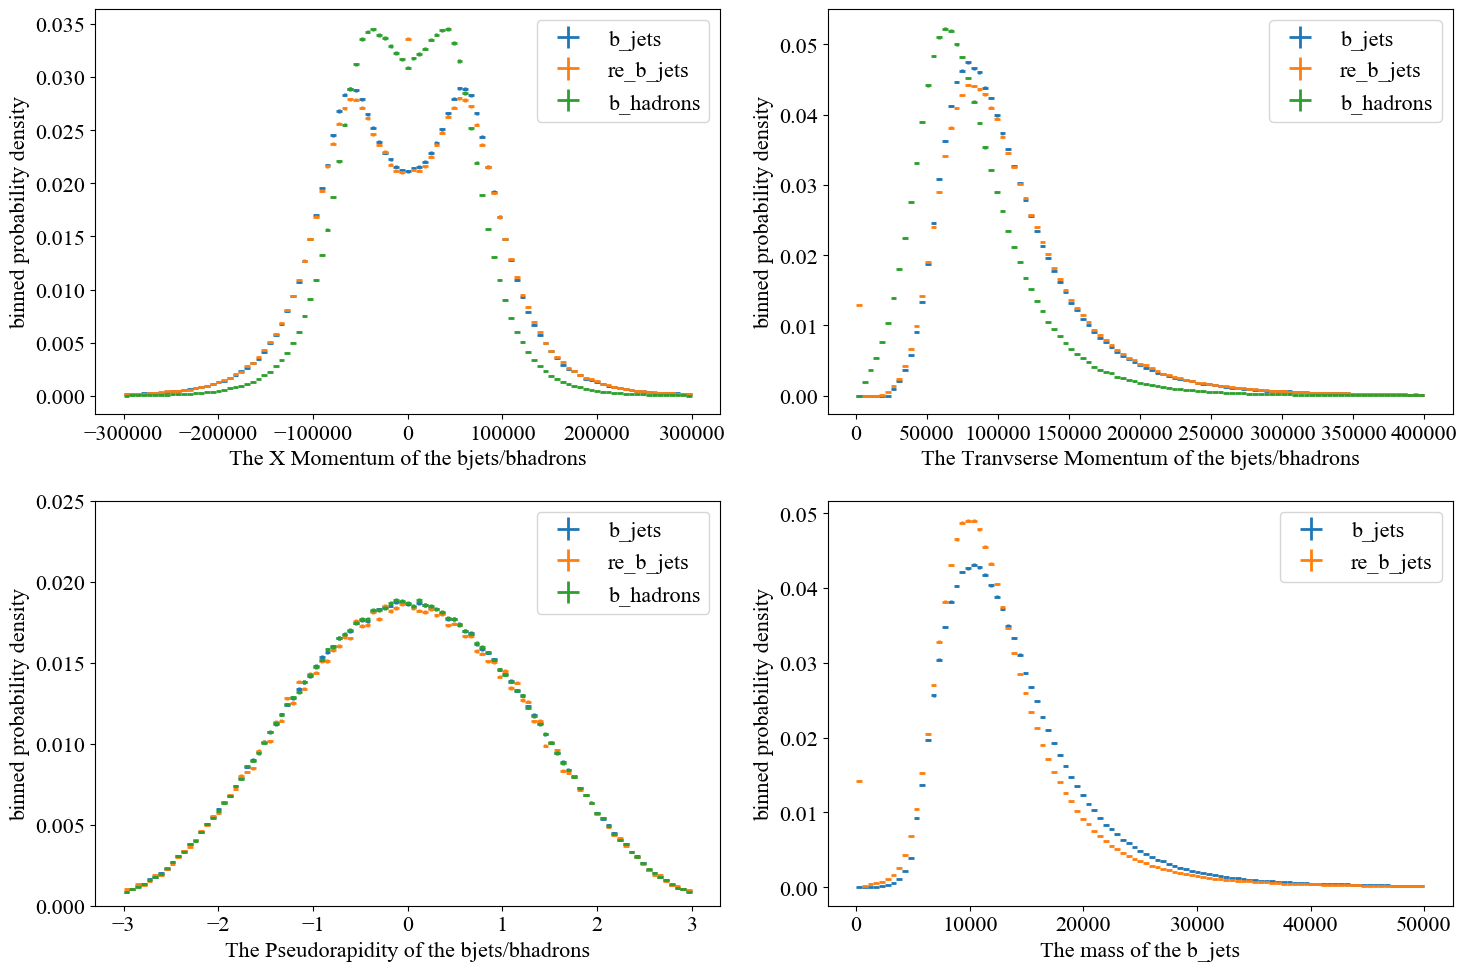

In [154]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
binneddensitysub(b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons", label = "b_jets")
binneddensitysub(re_b_jets[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = " The X Momentum of the bjets/bhadrons", label = "re_b_jets")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,3], fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_pt, fixedbinning(0, 4e5,100), ax = axes[0,1], xlabel = "The Tranvserse Momentum of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,4], fixedbinning(-3.0, 3.0,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,4], fixedbinning(-3.0, 3.0,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the b_jets", label = "re_b_jets")
binneddensitysub(bhads_eta, fixedbinning(-3.0, 3.0,100), ax = axes[1,0], xlabel = "The Pseudorapidity of the bjets/bhadrons", label = "b_hadrons")
binneddensitysub(b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,1], xlabel = "The mass of the b_jets", label = "b_jets")
binneddensitysub(re_b_jets[:,6], fixedbinning(0, 5e4,100), ax = axes[1,1], xlabel = "The mass of the b_jets", label = "re_b_jets")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
axes[1,0].set_ylim([0,0.025])
plt.tight_layout()
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Jets_DistributionsUpdated.png", dpi = 500)

In [106]:
#Mask out the MASKVALs used to pad the arrays
tracks = np.ma.masked_values(tracks,-999)
sum_tracks_px = np.ma.sum(tracks[:,:,0],axis = 1)
sum_tracks_py = np.ma.sum(tracks[:,:,1],axis = 1)
sum_tracks_pz = np.ma.sum(tracks[:,:,2],axis = 1)
sum_tracks_pt = np.ma.sum(tracks[:,:,3],axis = 1)

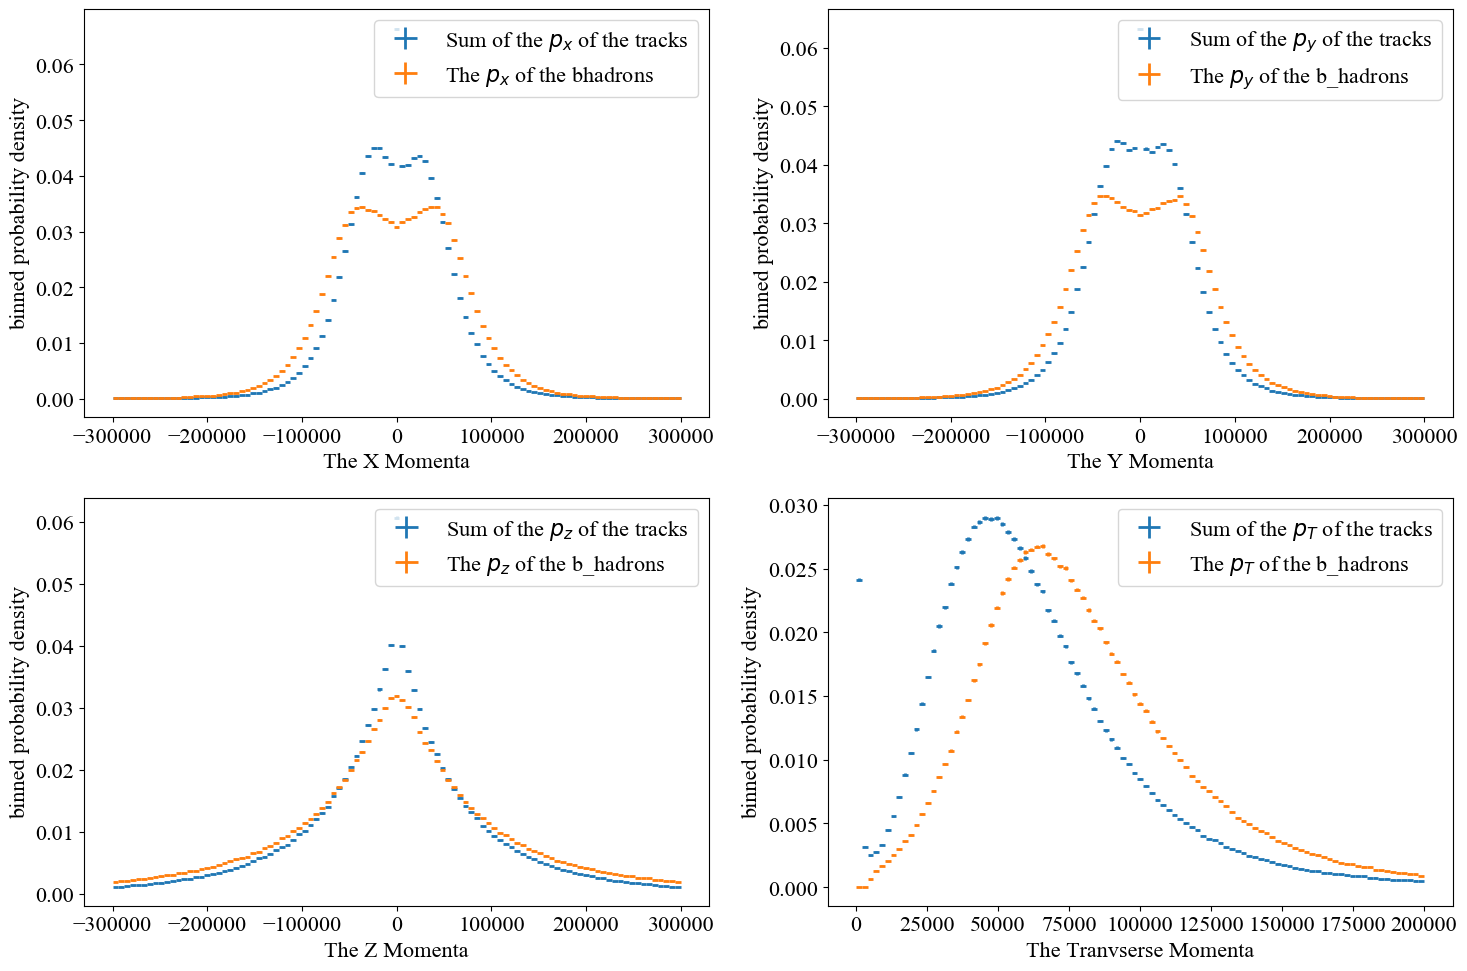

In [155]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
binneddensitysub(sum_tracks_px, fixedbinning(-3e5,3e5,100), ax = axes[0,0], xlabel="Sum of the X Momentum of the tracks", label = "Sum of the $p_x$ of the tracks")
binneddensitysub(bhads[:,0], fixedbinning(-3e5, 3e5,100), ax = axes[0,0], xlabel = "The X Momenta", label = "The $p_x$ of the bhadrons")
binneddensitysub(sum_tracks_py, fixedbinning(-3e5,3e5,100), ax = axes[0,1], label="Sum of the $p_y$ of the tracks" )
binneddensitysub(bhads[:,1], fixedbinning(-3e5, 3e5,100), ax = axes[0,1], xlabel = "The Y Momenta", label = "The $p_y$ of the b_hadrons")
binneddensitysub(sum_tracks_pz, fixedbinning(-3e5,3e5,100), ax = axes[1,0], xlabel="Sum of the Z Momentum of the tracks", label = "Sum of the $p_z$ of the tracks")
binneddensitysub(bhads[:,2], fixedbinning(-3e5, 3e5,100), ax = axes[1,0], xlabel = "The Z Momenta", label = "The $p_z$ of the b_hadrons")
binneddensitysub(sum_tracks_pt, fixedbinning(0,2e5,100), ax = axes[1,1], xlabel="The sum of the Transverse Momentum of the tracks", label = "Sum of the $p_T$ of the tracks")
binneddensitysub(bhads_pt, fixedbinning(0, 2e5,100), ax = axes[1,1], xlabel = "The Tranvserse Momenta", label = "The $p_T$ of the b_hadrons")
for i, ax in enumerate(axes):
    for j,ax in enumerate(axes):
        axes[i,j].legend(loc = "upper right")
plt.tight_layout()
plt.show()
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/Sum_Of_Tracks_Distributions.png", dpi = 500)

In [123]:
history = pd.read_csv('/home/physics/phujdj/DeepLearningParticlePhysics/ResNetDeepSetOriginalNew.csv')

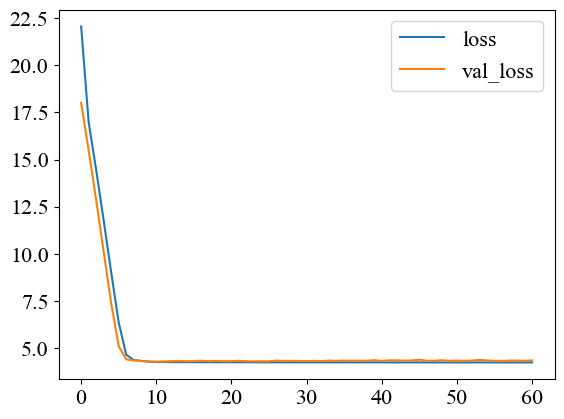

In [129]:
axes = np.log(history.loc[:, ["loss","val_loss"]]).plot()

In [6]:
Predictions_Original = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/PredictionsOriginal.npy")
Predictions_Original.shape

(480831, 77)

In [7]:
bhads_targets_original = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Original_bhads_targets.npy")
bhads_targets_original.shape

(480831, 11)

In [8]:
lister = []
index = 0
predictions_x = Predictions_Original[:,:np.shape(bhads_targets_original)[1]]
predictions_X = predictions_x
predictions_x_uncertainty = Predictions_Original[:,np.shape(bhads_targets_original)[1]:2*np.shape(bhads_targets_original)[1]]
Predictions_Uncertainty = predictions_x_uncertainty

In [9]:
Error_px_unscaled = (bhads_targets_original[:,0] - predictions_X[:,0])
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets_original[:,0])
Pull_px = Error_px_unscaled/(Predictions_Uncertainty[:,0])

In [10]:
Error_py_unscaled = (bhads_targets_original[:,1] - predictions_X[:,1])
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets_original[:,1])
Pull_py = Error_py_unscaled/(Predictions_Uncertainty[:,1])

In [11]:
Error_pz_unscaled = (bhads_targets_original[:,2] - predictions_X[:,2])
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets_original[:,2])
Pull_pz = Error_pz_unscaled/(Predictions_Uncertainty[:,2])

In [12]:
Error_pt_unscaled = (bhads_targets_original[:,3] - predictions_X[:,3])
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_original[:,3])
Pull_pt = Error_pt_unscaled/(Predictions_Uncertainty[:,3])

In [13]:
Error_eta_unscaled = bhads_targets_original[:,4] - predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta_unscaled/np.std(bhads_targets_original[:,4])
Pull_eta = Error_eta_unscaled/Predictions_Uncertainty[:,4]

In [14]:
Error_phi_unscaled = bhads_targets_original[:,5] - predictions_X[:,5]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_original[:,5])
Pull_phi = Error_phi_unscaled/Predictions_Uncertainty[:,5]

In [15]:
Error_ptfraction_unscaled = bhads_targets_original[:,6] - predictions_X[:,6]
Pull_ptfraction_unscaled = Error_ptfraction_unscaled/np.std(bhads_targets_original[:,6])
Pull_ptfraction = Error_ptfraction_unscaled/Predictions_Uncertainty[:,6]

In [16]:
Error_projection_unscaled = bhads_targets_original[:,7] - predictions_X[:,7]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_original[:,7])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,7]

In [17]:
Error_projectiont_unscaled = bhads_targets_original[:,8] - predictions_X[:,8]
Pull_bhads_projectiont_unscaled = Error_projection_unscaled/np.std(bhads_targets_original[:,8])
Pull_projectiont = Error_projectiont_unscaled/Predictions_Uncertainty[:,8]

In [18]:
Error_energy_unscaled = (bhads_targets_original[:,-1] - predictions_X[:,-1])
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_original[:,-1])
Pull_energy = Error_energy_unscaled/(Predictions_Uncertainty[:,-1])

<AxesSubplot:>

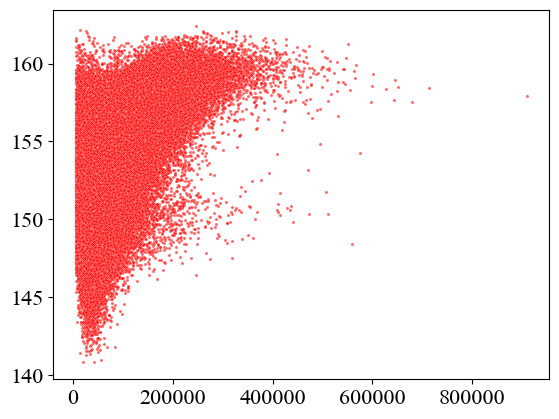

In [30]:
sns.scatterplot(x = bhads_targets_original[:,3], y = predictions_X[:,3], s = 5, alpha = 0.6, color = "red")

In [21]:
import matplotlib as mpl
from scipy.stats import gaussian_kde
def kde_generator(x,y, ax, s, alpha, cmap):
    grid = np.vstack([x, y])
    z = gaussian_kde(grid)(grid)
    idx = z.argsort()
    x,y,z = x[idx], y[idx], z[idx]
    im = sns.scatterplot(x,y,c = z,s = s, ax = ax, alpha = alpha, cmap = cmap)
    norm = plt.Normalize(z.min(), z.max())
    sm = plt.cm.ScalarMappable(cmap = cmap, norm = norm)
    sm.set_array([])
    #im.figure.colorbar(sm, cax = ax_2, orientation="horizontal", pad=0.2)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    return ax, sm

In [22]:
# define two functions to aid in plotting
def hist(xs, binning, normalized=False):
  ys = np.histogram(xs, bins=binning)[0]

  yerrs = np.sqrt(ys)

  if normalized:
    s = np.sum(ys)
    ys = ys / s
    yerrs = yerrs / s

  return ys, yerrs
def binneddensitysub(xs, binning, ax, label=None, xlabel=None, ylabel="binned probability density"):
  #fig = figure.Figure(figsize=(8, 8))
  #plt = fig.add_subplot(111)

  ys , yerrs = hist(xs, binning, normalized=True)

  # determine the central value of each histogram bin
  # as well as the width of each bin
  # this assumes a fixed bin size.
  xs = (binning[1:]+binning[:-1]) / 2.0
  xerrs = ((binning[1:]-binning[:-1]) / 2.0)

  ax.errorbar \
    ( xs
    , ys
    , xerr=xerrs
    , yerr=yerrs
    , label=label
    , linewidth=0
    , elinewidth=2
    , marker = 'None'
    )

  ax.set_xlabel(xlabel, fontsize = 16)
  ax.set_ylabel(ylabel, fontsize = 16)
  ax.tick_params(axis='x', labelsize=12)
  ax.tick_params(axis='y', labelsize=12)

  return ax

In [23]:
def IQR(element):
    return np.quantile(element,0.75) - np.quantile(element,0.25)

In [20]:
plt.rcParams.update({'font.size': 16})
from sklearn.metrics import r2_score
from hffrag import binneddensitysub

In [26]:
np.min(predictions_X[:900,3]), np.max(predictions_X[:900,3])

(144.74663, 161.04968)

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

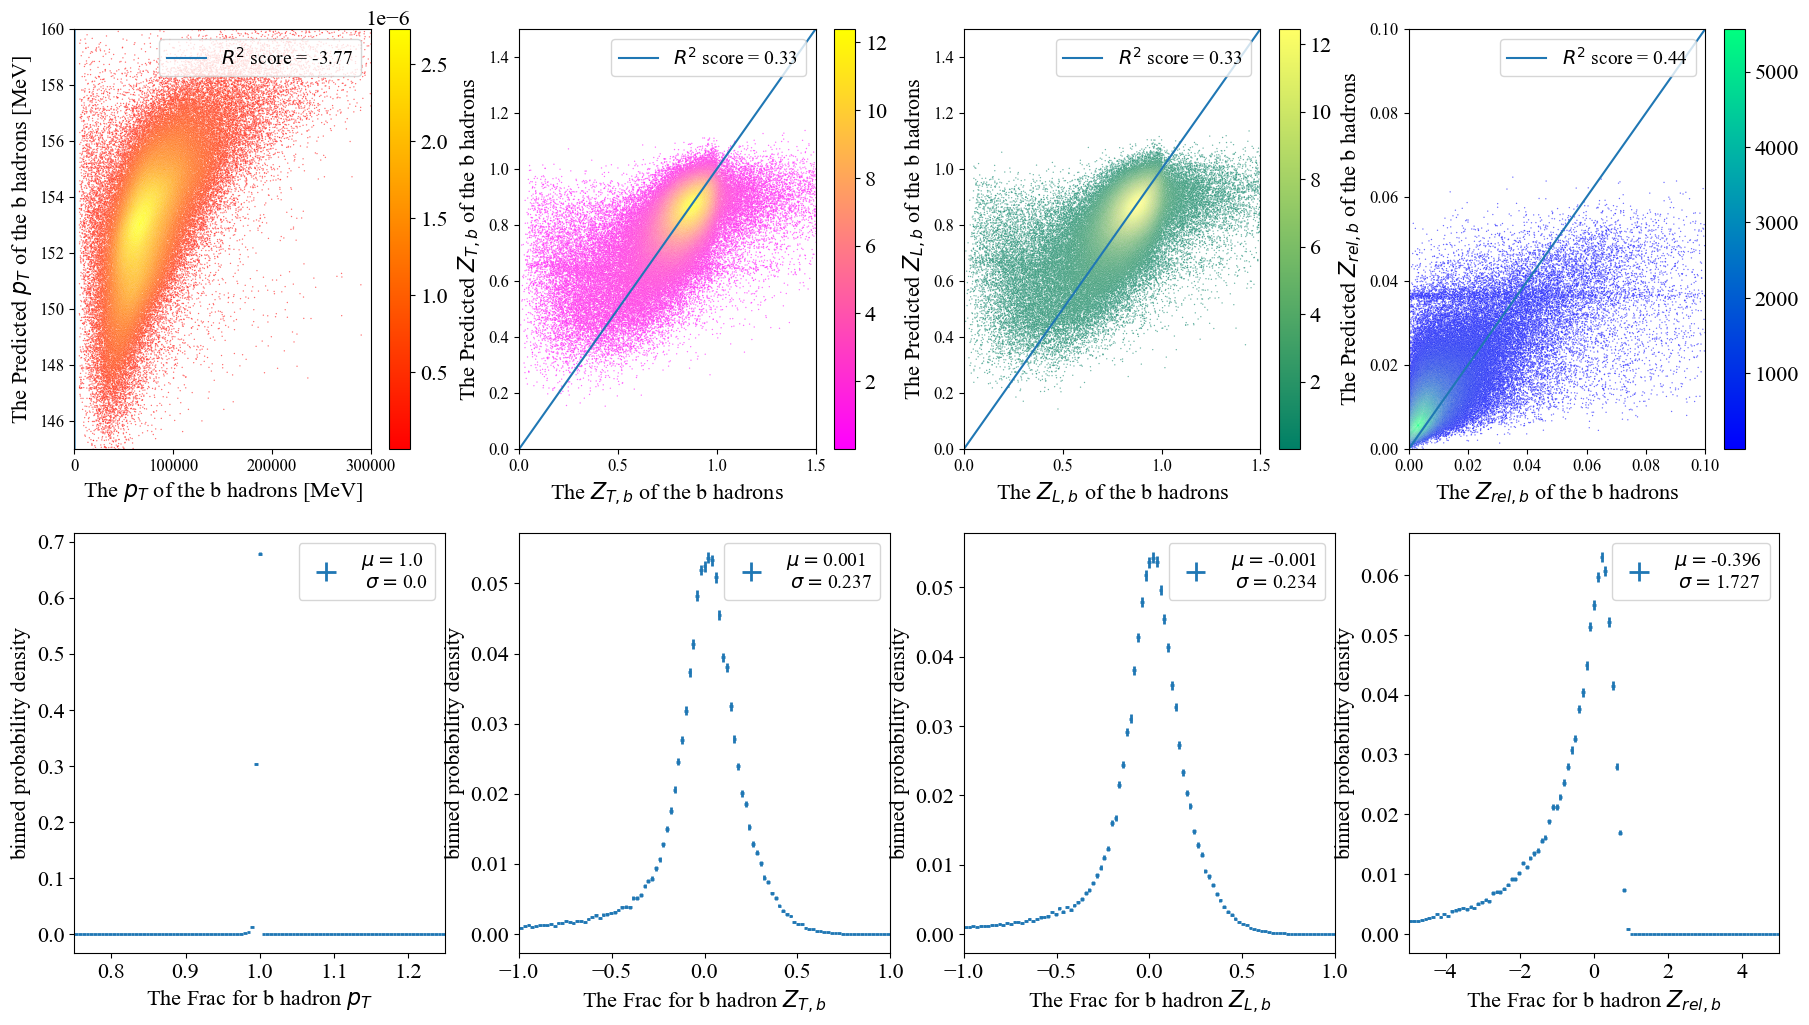

In [48]:
Figure, axes = plt.subplots(2,4, figsize = (22,12))
#l1 = sns.scatterplot(x = bhads_targets[:,3], y = Predictions[:,3], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1, sm_1 = kde_generator(x = bhads_targets_original[:90000,3], y = predictions_X[:90000,3],ax = axes[0,0], s = 1, alpha = 0.6, cmap = "autumn")
Figure.colorbar(sm_1,ax = axes[0,0])
l1_score = r2_score(bhads_targets_original[:90000,3], predictions_X[:90000,3])
x = np.linspace(0, 4e5)
l1.set_xlabel("The $p_T$ of the b hadrons [MeV]")
l1.set_ylabel("The Predicted $p_T$ of the b hadrons [MeV]")
error_pt = (bhads_targets_original[:90000,3] - predictions_X[:90000,3])/bhads_targets_original[:90000,3]
mean_error_pt, std_error_pt = np.median(error_pt), IQR(error_pt)
l1.plot(x,x)
binneddensitysub(error_pt, fixedbinning(0.75,1.25,100), ax = axes[1,0], xlabel= "The Frac for b hadron $p_T$")
#l2 = sns.scatterplot(x = bhads_targets[:,6], y = Predictions[:,6], ax = axes[0,1], s = 1, alpha = 0.6, color = "orange")
l2, sm_2 = kde_generator(x = bhads_targets_original[:90000,6], y = predictions_X[:90000,6], ax = axes[0,1], s = 1, alpha = 0.6, cmap = "spring")
Figure.colorbar(sm_2,ax = axes[0,1])
l2_score = r2_score(bhads_targets_original[:90000,6], predictions_X[:90000,6])
x = np.linspace(0, 4)
error_pt_fraction = (bhads_targets_original[:90000,6] - predictions_X[:90000,6])/bhads_targets_original[:90000,6]
mean_error_pt_fraction, std_error_pt_fraction = np.median(error_pt_fraction), IQR(error_pt_fraction)
l2.plot(x,x)
l2.set_xlabel("The $Z_{T,b}$ of the b hadrons")
l2.set_ylabel("The Predicted $Z_{T,b}$ of the b hadrons")
binneddensitysub(error_pt_fraction, fixedbinning(-1,1,100), ax = axes[1,1], xlabel="The Frac for b hadron $Z_{T,b}$")
#l3 = sns.scatterplot(x = bhads_targets[:,7], y = Predictions[:,7], ax = axes[0,2], s = 1, alpha = 0.6, color = "brown")
l3, sm_3 = kde_generator(x = bhads_targets_original[:90000,7], y = predictions_X[:90000,7], ax = axes[0,2], s = 1, alpha = 0.6, cmap = "summer")
Figure.colorbar(sm_3,ax = axes[0,2])
l3_score = r2_score(bhads_targets_original[:90000,7], predictions_X[:90000,7])
x = np.linspace(0, 4)
error_lprojection = (bhads_targets_original[:90000,7] - predictions_X[:90000 ,7])/bhads_targets_original[:90000,7]
mean_error_lprojection, std_error_lprojection = np.median(error_lprojection), IQR(error_lprojection)
l3.plot(x,x)
l3.set_xlabel("The $Z_{L,b}$ of the b hadrons")
l3.set_ylabel("The Predicted $Z_{L,b}$ of the b hadrons")
binneddensitysub(error_lprojection, fixedbinning(-1,1,100), ax = axes[1,2], xlabel="The Frac for b hadron $Z_{L,b}$")
l4, sm_4 = kde_generator(x = bhads_targets_original[:90000,8], y = predictions_X[:90000,8], ax = axes[0,3], s = 1, alpha = 0.6, cmap = "winter")
Figure.colorbar(sm_4,ax = axes[0,3])
l4_score = r2_score(bhads_targets_original[:90000,8], predictions_X[:90000,8])
x = np.linspace(0, 0.2)
error_tprojection = (bhads_targets_original[:90000,8] - predictions_X[:90000 ,8])/bhads_targets_original[:90000,8]
mean_error_tprojection, std_error_tprojection = np.median(error_tprojection), IQR(error_tprojection)
l4.plot(x,x)
l4.set_xlabel("The $Z_{rel,b}$ of the b hadrons")
l4.set_ylabel("The Predicted $Z_{rel,b}$ of the b hadrons")
binneddensitysub(error_tprojection, fixedbinning(-5,5,100), ax = axes[1,3], xlabel="The Frac for b hadron $Z_{rel,b}$")
axes[0,0].set_ylim(145,160)
axes[0,0].legend([f"$R^2$ score = {round(l1_score,2)}"], loc = "upper right", fontsize = 14)
axes[0,0].set_xlim(0,3e5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt,2)}\n $\sigma = ${round(std_error_pt,2)}"], loc = "upper right", fontsize = 14)
axes[0,1].set_xlim(0,1.5)
axes[0,1].set_ylim(0,1.5)
axes[0,1].legend([f"$R^2$ score = {round(l2_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,1].legend([f"$\mu = ${round(mean_error_pt_fraction,3)}\n $\sigma = ${round(std_error_pt_fraction,3)}"], loc = "upper right", fontsize = 14)
axes[0,2].legend([f"$R^2$ score = {round(l3_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,2].legend([f"$\mu = ${round(mean_error_lprojection,3)}\n $\sigma = ${round(std_error_lprojection,3)}"], loc = "upper right", fontsize = 14)
axes[0,3].legend([f"$R^2$ score = {round(l4_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,3].legend([f"$\mu = ${round(mean_error_tprojection,3)}\n $\sigma = ${round(std_error_tprojection,3)}"], loc = "upper right", fontsize = 14)
axes[0,2].set_ylim(0,1.5)
axes[0,2].set_xlim(0,1.5)
axes[0,3].set_ylim(0,0.1)
axes[0,3].set_xlim(0,0.1)
axes[1,0].set_xlim(0.75,1.25)
axes[1,1].set_xlim(-1,1)
axes[1,2].set_xlim(-1,1)
axes[1,3].set_xlim(-5,5)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJetsInitial.png")

In [23]:
Pull_pt_mean, Pull_pt_std = np.mean(Pull_pt), np.std(Pull_pt)
Pull_eta_mean, Pull_eta_std = np.mean(Pull_eta), np.std(Pull_eta)
Pull_phi_mean, Pull_phi_std = np.mean(Pull_phi), np.std(Pull_phi)
Pull_pt_mean_fraction, Pull_pt_std_fraction = np.mean(Pull_ptfraction), np.std(Pull_ptfraction)
Pull_projection_mean, Pull_projection_std = np.mean(Pull_projection), np.std(Pull_projection)
Pull_projectiont_mean, Pull_projectiont_std = np.mean(Pull_projectiont), np.std(Pull_projectiont)
Pull_energy_mean, Pull_energy_std = np.mean(Pull_energy), np.std(Pull_energy)

[-0.57916193 -1.04682963 -0.56427619 ...  0.79062674 -0.67231124
  1.06316482]


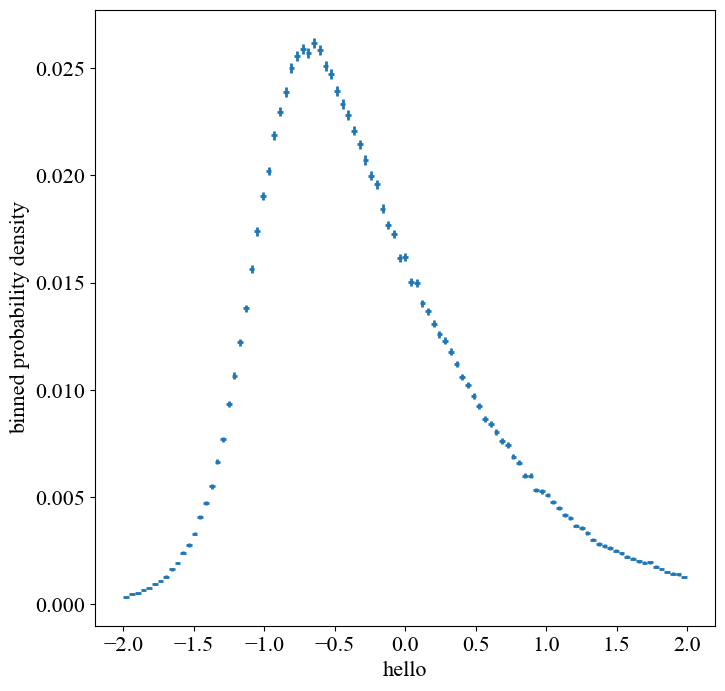

In [31]:
print(Pull_projectiont)
binneddensity(Pull_projectiont,fixedbinning(-2,2,100), xlabel="hello")

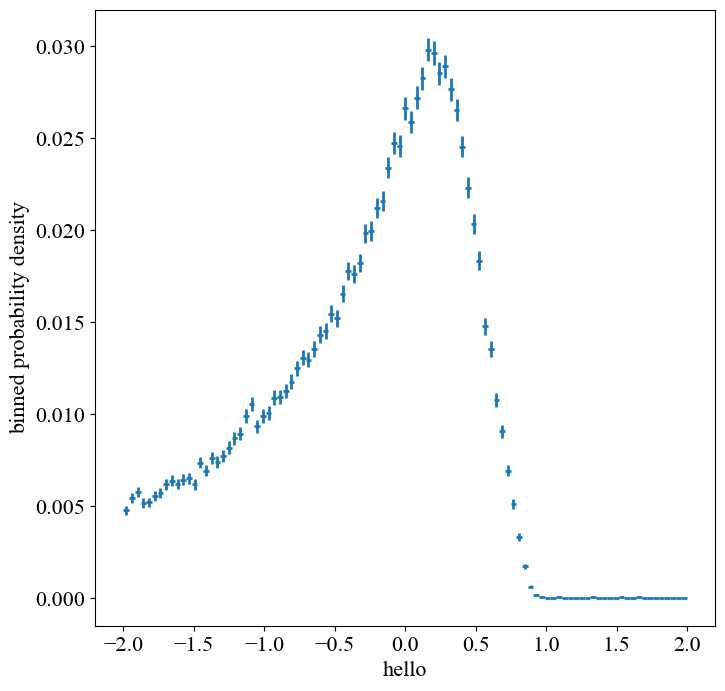

In [49]:
binneddensity(error_tprojection,fixedbinning(-2,2,100), xlabel="hello")

In [72]:
bhads_error2 = bhads_targets_original[:,8] - predictions_X[: ,8]
print(np.min(bhads_error2))
print(np.max(bhads_error2))

-0.053096959873229634
0.4966021857824533


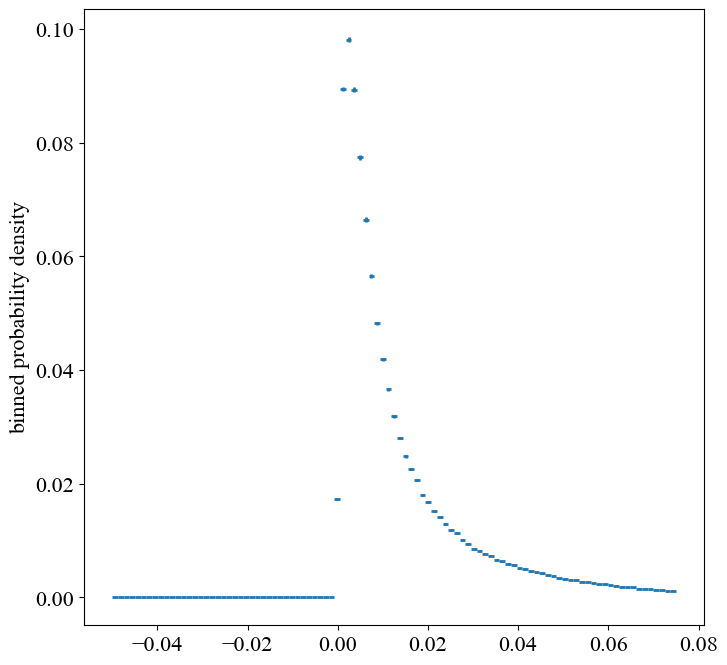

In [63]:
binneddensity(bhads_targets_original[:,8], fixedbinning(-0.05,0.075,100))

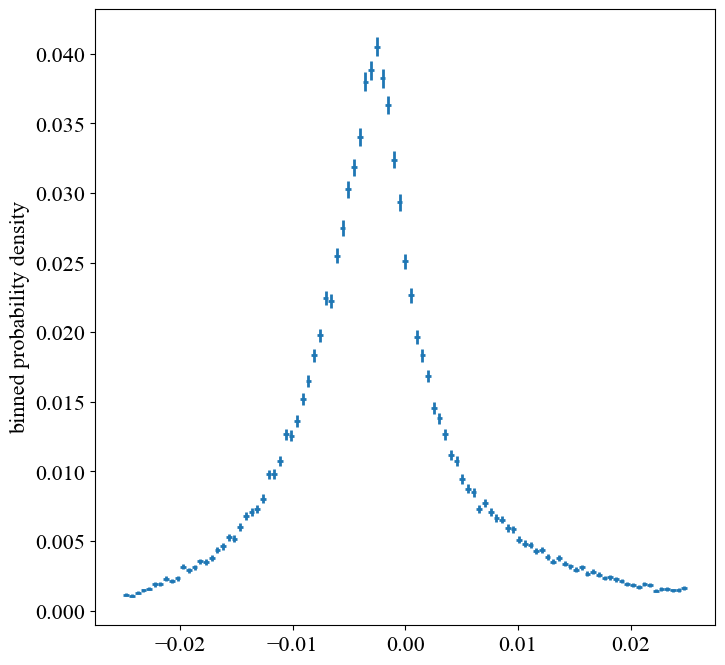

In [69]:
binneddensity(bhads_error2, fixedbinning(-0.025,0.025,100))

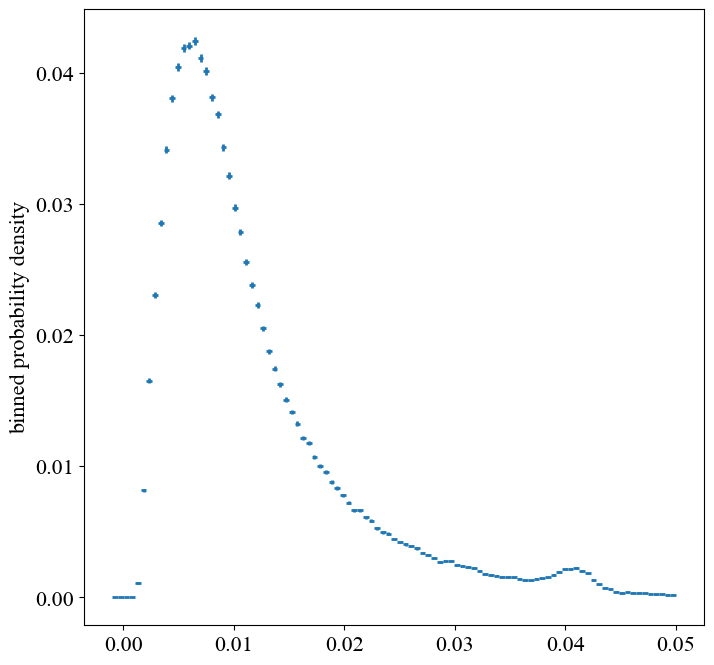

In [61]:
binneddensity(Predictions_Uncertainty[:,8], fixedbinning(-0.001,0.05,100))

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


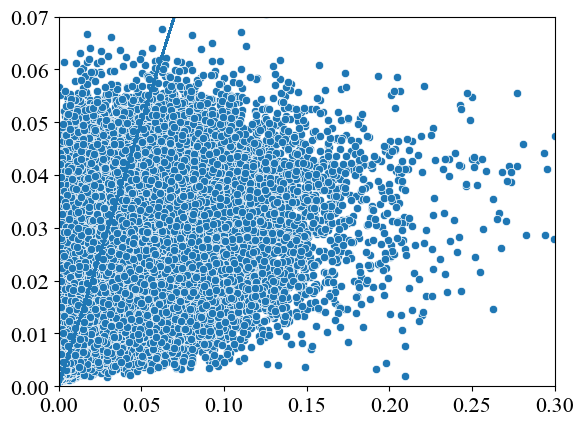

In [83]:
x = bhads_targets_original[:,8]
y = Predictions_Uncertainty[:,8]
sns.scatterplot(x,y)
plt.xlim([0,0.3])
plt.ylim([0,0.07])
plt.plot(x,x)
plt.show()

In [84]:
r2_score(x,y)

0.33124663641115293

In [47]:
print(np.median(Pull_projectiont))
print(np.mean(Pull_projectiont))
print(np.argmax(Pull_projectiont))
print("Fractional Difference")
error_tprojection = (bhads_targets_original[:90000,8] - predictions_X[:90000 ,8])/bhads_targets_original[:90000,8]
print(np.median(error_tprojection))
print(np.mean(error_tprojection))

-0.36871158476982985
-0.15447371498096724
454652
Fractional Difference
-0.3960029872187033
-210.95974864604443


In [ ]:
print(np.unique(Pull_pt_fun))

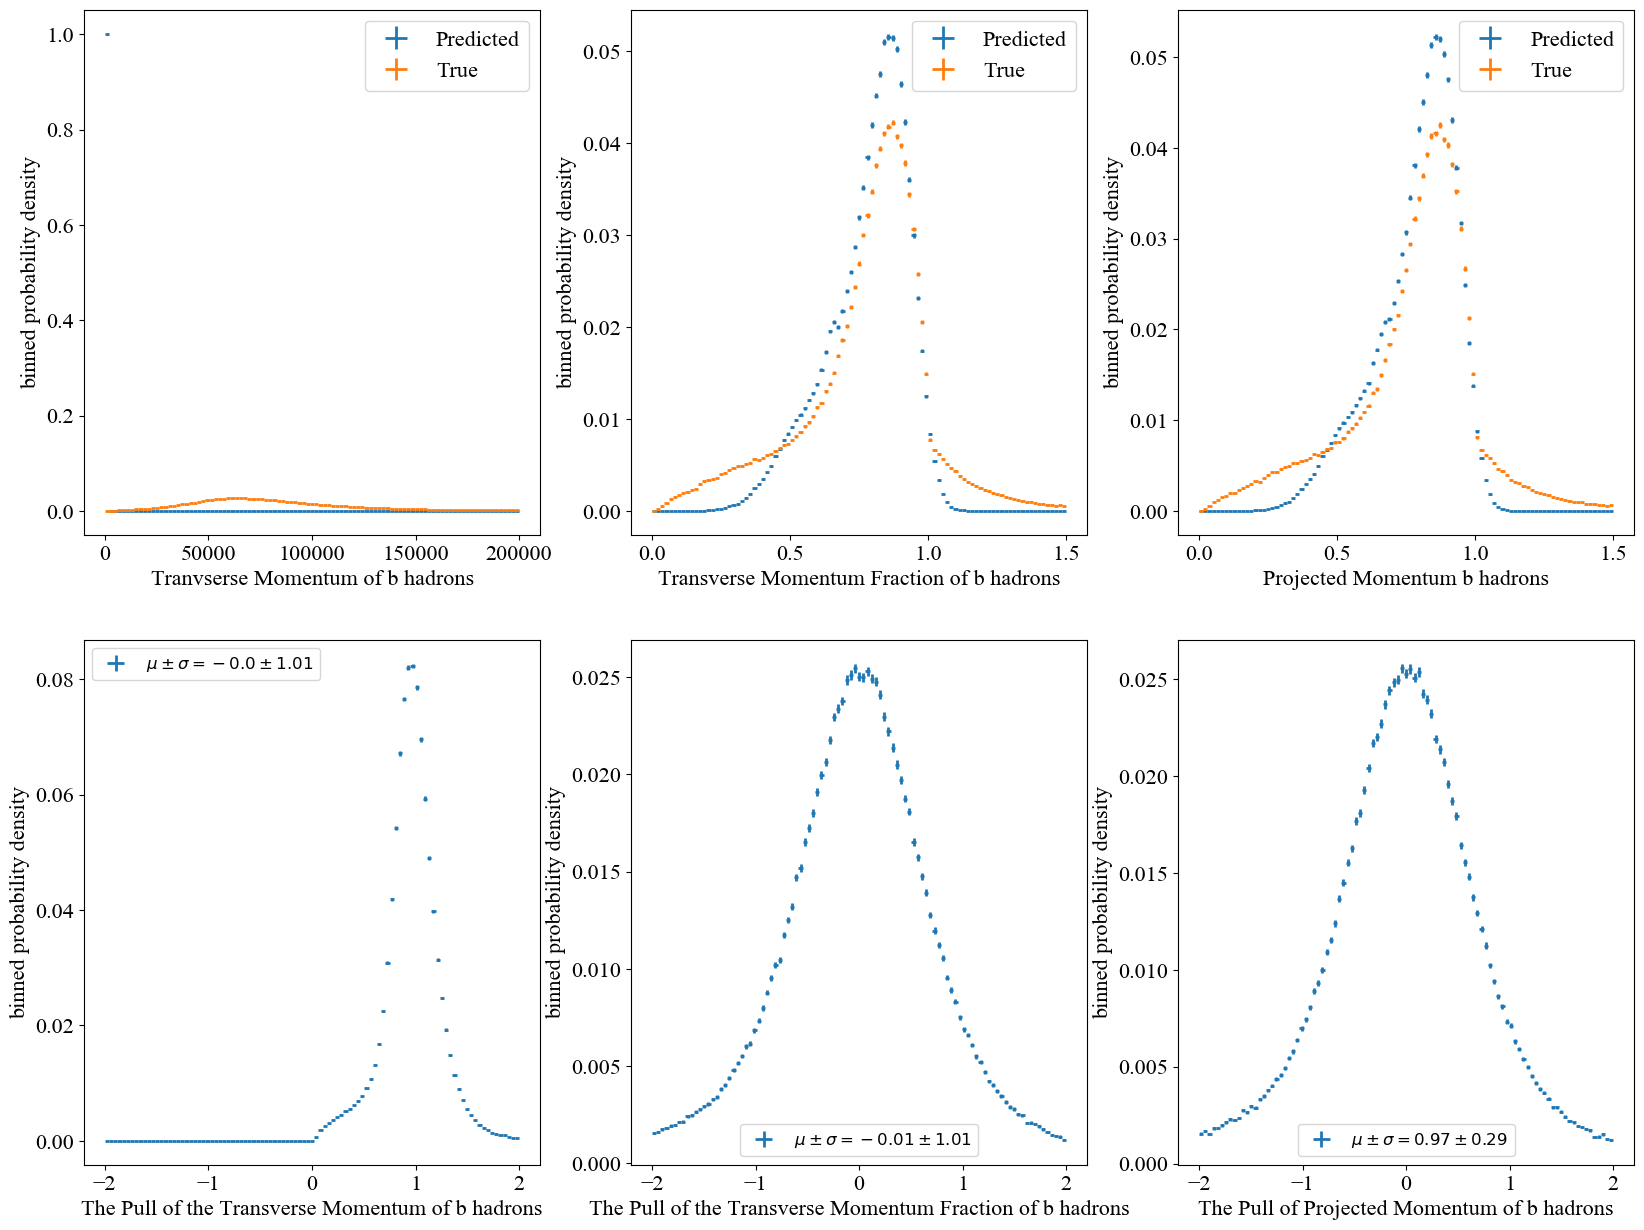

In [24]:
Figure, axes = plt.subplots(2,3, figsize = (20,15))
l1 = binneddensitysub(predictions_X[:,3], fixedbinning(0,2e5,100), ax = axes[0,0], xlabel = "Predicted Tranvserse Momentum of b hadrons", label = "Predicted")
l2 = binneddensitysub(predictions_X[:,6], fixedbinning(0,1.5,100), ax = axes[0,1], xlabel = "Predicted Transverse Momentum Fraction of b hadrons", label = "Predicted")
l3 = binneddensitysub(predictions_X[:,7], fixedbinning(0,1.5,100), ax = axes[0,2], xlabel = "Predicted Projected Momentum of b hadrons", label = "Predicted")
l4 = binneddensitysub(bhads_targets_original[:,3], fixedbinning(0,2e5,100), ax = axes[0,0], xlabel = "Tranvserse Momentum of b hadrons", label = "True")
l5 = binneddensitysub(bhads_targets_original[:,6], fixedbinning(0, 1.5, 100), ax = axes[0,1], xlabel= "Transverse Momentum Fraction of b hadrons", label = "True")
l6 = binneddensitysub(bhads_targets_original[:,7], fixedbinning(0,1.5,100), ax = axes[0,2], xlabel = "Projected Momentum b hadrons", label = "True")
l7 = binneddensitysub(Pull_pt, fixedbinning(-2,2,100), ax = axes[1,0], xlabel = "The Pull of the Transverse Momentum of b hadrons",)
l8 = binneddensitysub(Pull_ptfraction, fixedbinning(-2,2,100), ax = axes[1,1], xlabel = "The Pull of the Transverse Momentum Fraction of b hadrons")
l9 = binneddensitysub(Pull_projection, fixedbinning(-2,2,100), ax = axes[1,2], xlabel = "The Pull of Projected Momentum of b hadrons")
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean_fraction,2)} \pm {round(Pull_pt_std_fraction,2)}$"], fontsize = 12)
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_projection_mean,2)} \pm {round(Pull_projection_std,2)}$"], fontsize = 12)
axes[1,2].legend([f"$\mu \pm \sigma = {round(Pull_energy_mean,2)} \pm {round(Pull_energy_std,2)}$"], fontsize = 12)
axes[0,0].legend(loc = "upper right")
axes[0,1].legend(loc = "upper right")
axes[0,2].legend(loc = "upper right")
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJets21.pdf", dpi = 500)

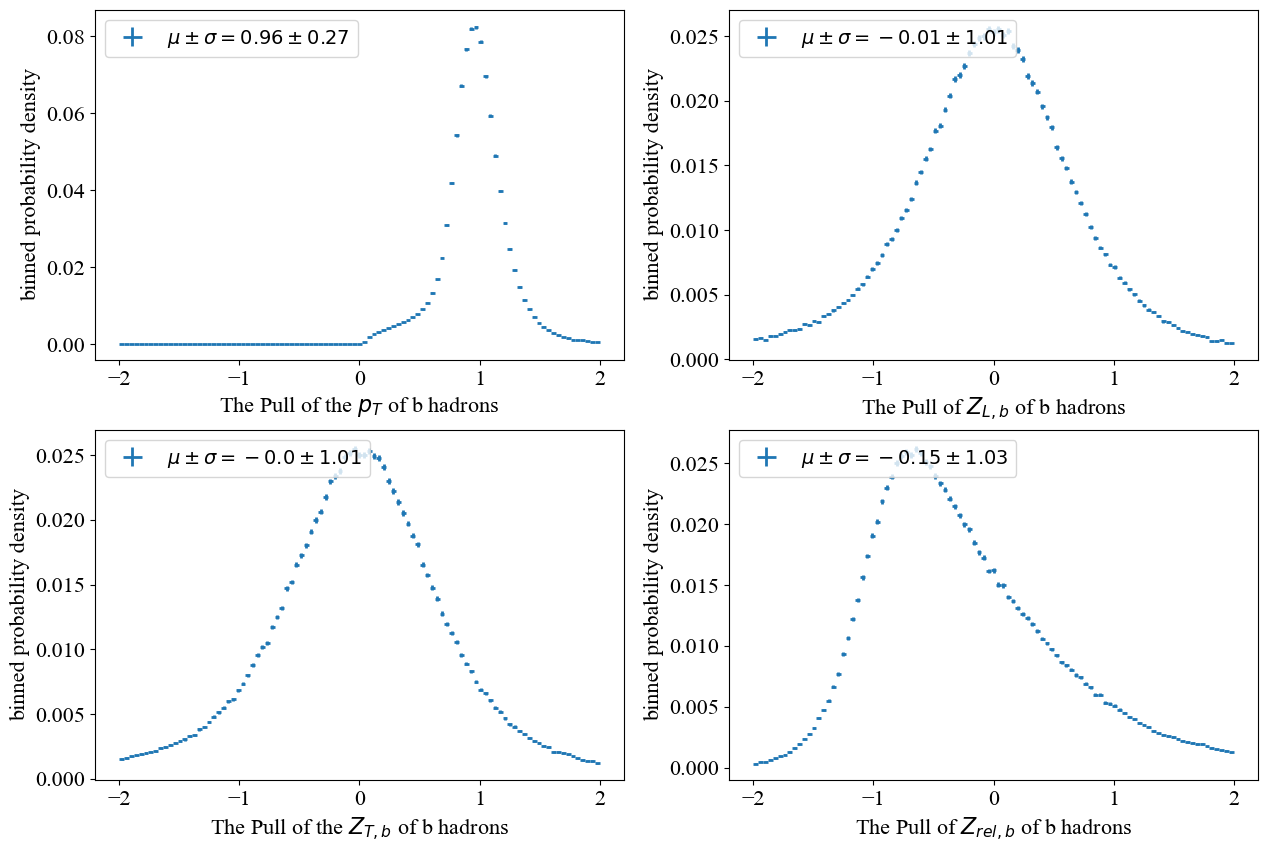

In [25]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
l7 = binneddensitysub(Pull_pt, fixedbinning(-2,2,100), ax = axes[0,0], xlabel = "The Pull of the $p_T$ of b hadrons",)
l8 = binneddensitysub(Pull_ptfraction, fixedbinning(-2,2,100), ax = axes[1,0], xlabel = "The Pull of the $Z_{T,b}$ of b hadrons")
l9 = binneddensitysub(Pull_projection, fixedbinning(-2,2,100), ax = axes[0,1], xlabel = "The Pull of $Z_{L,b}$ of b hadrons")
l10 = binneddensitysub(Pull_projectiont, fixedbinning(-2,2,100), ax = axes[1,1], xlabel = "The Pull of $Z_{rel,b}$ of b hadrons")
axes[0,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean,2)} \pm {round(Pull_pt_std,2)}$"],loc = "upper left", fontsize = 14)
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean_fraction,2)} \pm {round(Pull_pt_std_fraction,2)}$"], loc = "upper left", fontsize = 14)
axes[0,1].legend([f"$\mu \pm \sigma = {round(Pull_projection_mean,2)} \pm {round(Pull_projection_std,2)}$"], loc = "upper left", fontsize = 14)
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_projectiont_mean,2)} \pm {round(Pull_projectiont_std,2)}$"], loc = "upper left", fontsize = 14)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJetsInitial2.png", dpi = 500)

In [88]:
Predictions_Final = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/FinalPredictions.npy")
Predictions_Final.shape

(480831, 189)

In [87]:
bhads_targets_Final = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Final_bhads_targets.npy")
bhads_targets_Final.shape

(480831, 18)

In [89]:
lister = []
index = 0
predictions_x = Predictions_Final[:,:np.shape(bhads_targets_Final)[1]]
predictions_X = predictions_x
predictions_x_uncertainty = Predictions_Final[:,np.shape(bhads_targets_Final)[1]:2*np.shape(bhads_targets_Final)[1]]
Predictions_Uncertainty = predictions_x_uncertainty

In [90]:
Error_px_unscaled = (bhads_targets_Final[:,0] - predictions_X[:,0])*1e6
Pull_bhads_px_unscaled = Error_px_unscaled/np.std(bhads_targets_Final[:,0]*1e6)
Pull_px = Error_px_unscaled/(Predictions_Uncertainty[:,0]*1e6)

In [91]:
Error_py_unscaled = (bhads_targets_Final[:,1] - predictions_X[:,1])*1e6
Pull_bhads_py_unscaled = Error_py_unscaled/np.std(bhads_targets_Final[:,1]*1e6)
Pull_py = Error_py_unscaled/(Predictions_Uncertainty[:,1]*1e6)

In [92]:
Error_pz_unscaled = (bhads_targets_Final[:,2] - predictions_X[:,2])*1e6
Pull_bhads_pz_unscaled = Error_pz_unscaled/np.std(bhads_targets_Final[:,2]*1e6)
Pull_pz = Error_pz_unscaled/(Predictions_Uncertainty[:,2]*1e6)

In [93]:
Error_pt_unscaled = (bhads_targets_Final[:,3] - predictions_X[:,3])*1e6
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_Final[:,3]*1e6)
Pull_pt = Error_pt_unscaled/(Predictions_Uncertainty[:,3]*1e6)

In [94]:
Error_eta_unscaled = bhads_targets_Final[:,4] - predictions_X[:,4]
Pull_bhads_eta_unscaled = Error_eta_unscaled/np.std(bhads_targets_Final[:,4])
Pull_eta = Error_eta_unscaled/Predictions_Uncertainty[:,4]

In [95]:
Error_phi_unscaled = bhads_targets_Final[:,5] - predictions_X[:,5]
Pull_bhads_pt_unscaled = Error_pt_unscaled/np.std(bhads_targets_Final[:,5])
Pull_phi = Error_phi_unscaled/Predictions_Uncertainty[:,5]

In [96]:
Error_energy_unscaled = (bhads_targets_Final[:,6] - predictions_X[:,6])*1e6
Pull_energy_unscaled = Error_energy_unscaled/np.std(bhads_targets_Final[:,6]*1e6)
Pull_energy = Error_energy_unscaled/(Predictions_Uncertainty[:,6]*1e6)

In [97]:
Error_ptfraction_unscaled = bhads_targets_Final[:,7] - predictions_X[:,7]
Pull_ptfraction_unscaled = Error_ptfraction_unscaled/np.std(bhads_targets_Final[:,7])
Pull_ptfraction = Error_ptfraction_unscaled/Predictions_Uncertainty[:,7]

In [98]:
Error_projection_unscaled = bhads_targets_Final[:,8] - predictions_X[:,8]
Pull_bhads_projection_unscaled = Error_projection_unscaled/np.std(bhads_targets_Final[:,8])
Pull_projection = Error_projection_unscaled/Predictions_Uncertainty[:,8]

-0.005767086188141465
0.9994481351752795


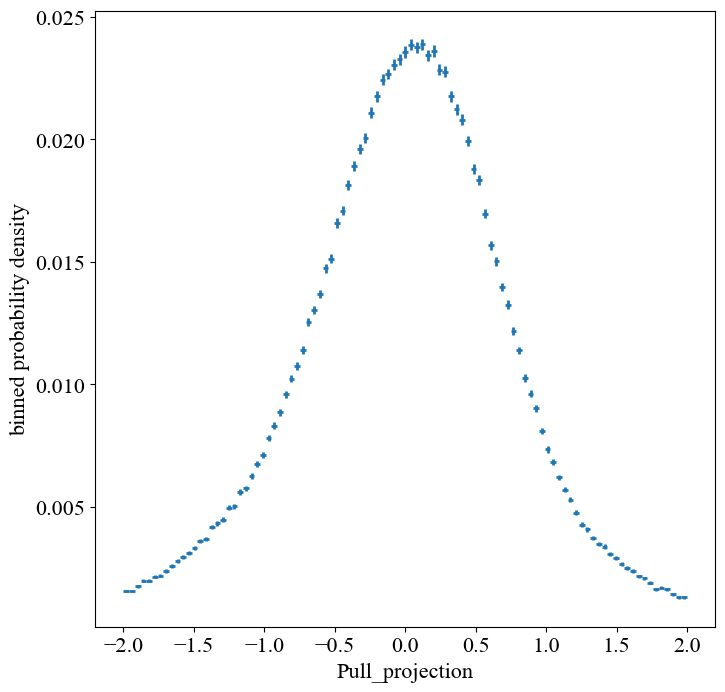

In [99]:
print(np.mean(Pull_projection))
print(np.std(Pull_projection))
binneddensity(Pull_projection, fixedbinning(-2,2,100),xlabel = "Pull_projection")

In [70]:
def IQR(element):
    return np.quantile(element,0.75) - np.quantile(element,0.25)

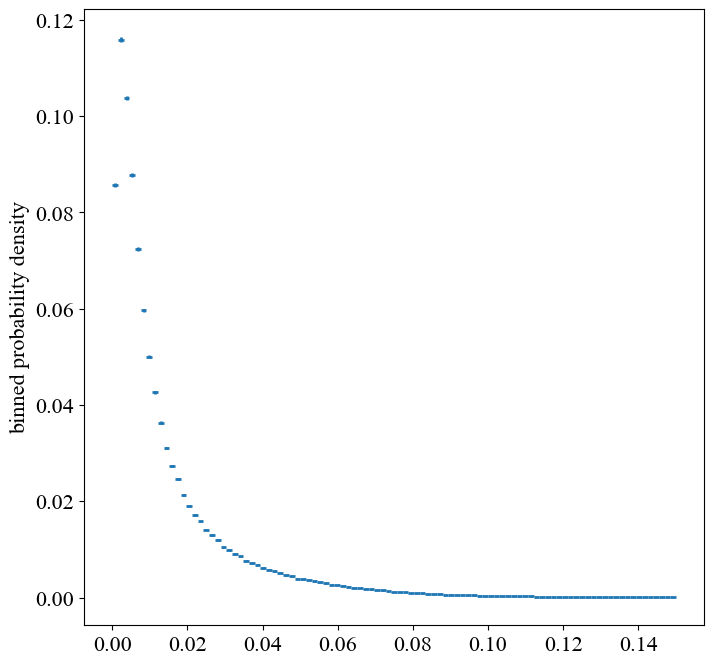

In [73]:
binneddensity(bhads_targets_Final[:,9], fixedbinning(0,0.15,100))

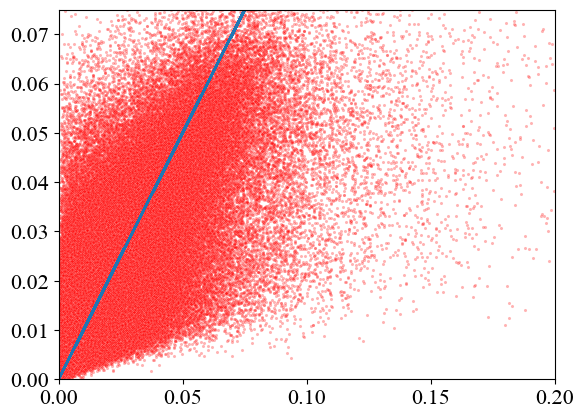

In [106]:
sns.scatterplot(x = bhads_targets_Final[:,9], y = predictions_X[:,9], s = 5, alpha = 0.3, color = "red")
plt.xlim([0,0.2])
plt.ylim([0,0.075])
plt.plot(x,x)

/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/physics/phujdj/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpr

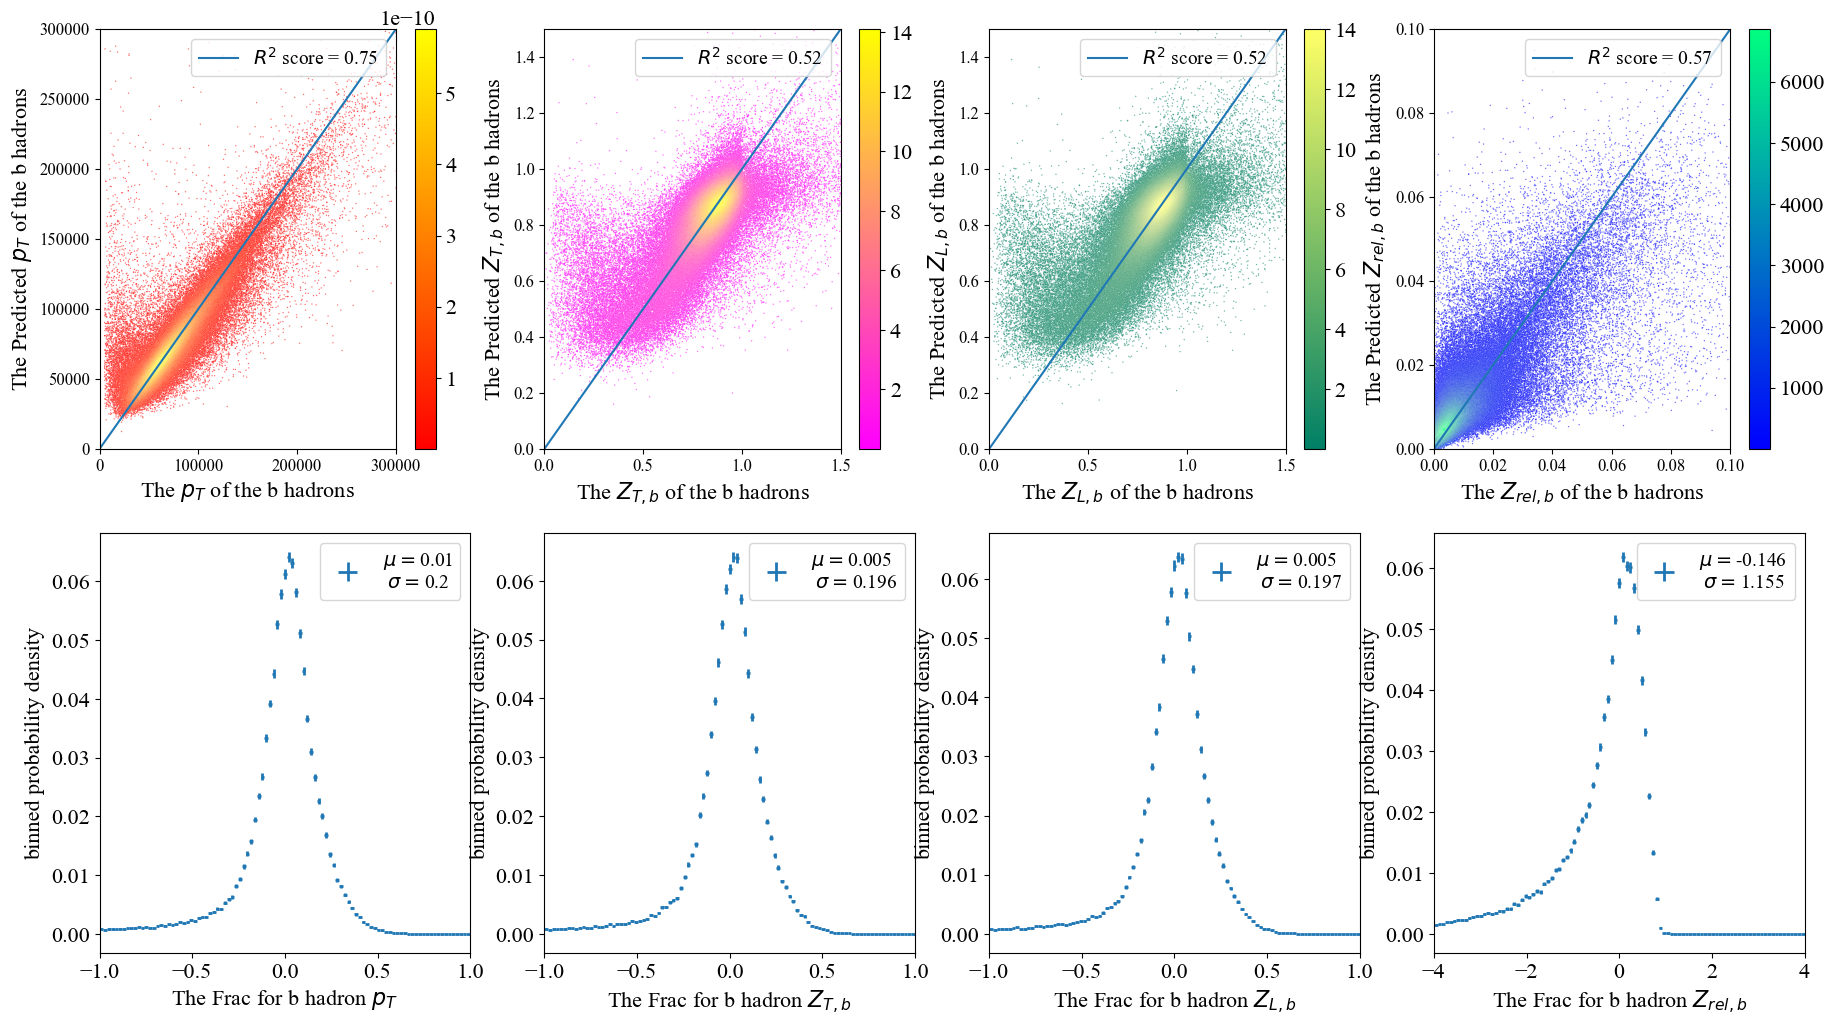

In [157]:
Figure, axes = plt.subplots(2,4, figsize = (22,12))
#l1 = sns.scatterplot(x = bhads_targets[:,3], y = Predictions[:,3], ax = axes[0,0], s = 5, alpha = 0.6, color = "red")
l1, sm_1 = kde_generator(x = bhads_targets_Final[:90000,3]*1e6, y = predictions_X[:90000,3]*1e6,ax = axes[0,0], s = 1, alpha = 0.6, cmap = "autumn")
Figure.colorbar(sm_1,ax = axes[0,0])
l1_score = r2_score(bhads_targets_Final[:90000,3]*1e6, predictions_X[:90000,3]*1e6)
x = np.linspace(0, 3e5)
l1.set_xlabel("The $p_T$ of the b hadrons")
l1.set_ylabel("The Predicted $p_T$ of the b hadrons")
error_pt = (bhads_targets_Final[:90000,3]*1e6 - predictions_X[:90000,3]*1e6)/(bhads_targets_Final[:90000,3]*1e6)
mean_error_pt, std_error_pt = np.median(error_pt), IQR(error_pt)
l1.plot(x,x)
binneddensitysub(error_pt, fixedbinning(-1,1,100), ax = axes[1,0], xlabel= "The Frac for b hadron $p_T$")
#l2 = sns.scatterplot(x = bhads_targets[:,6], y = Predictions[:,6], ax = axes[0,1], s = 1, alpha = 0.6, color = "orange")
l2, sm_2 = kde_generator(x = bhads_targets_Final[:90000,7], y = predictions_X[:90000,7], ax = axes[0,1], s = 1, alpha = 0.6, cmap = "spring")
Figure.colorbar(sm_2,ax = axes[0,1])
l2_score = r2_score(bhads_targets_Final[:90000,7], predictions_X[:90000,7])
x = np.linspace(0, 4)
error_pt_fraction = (bhads_targets_Final[:90000,7] - predictions_X[:90000,7])/bhads_targets_Final[:90000,7]
mean_error_pt_fraction, std_error_pt_fraction = np.median(error_pt_fraction), IQR(error_pt_fraction)
l2.plot(x,x)
l2.set_xlabel("The $Z_{T,b}$ of the b hadrons")
l2.set_ylabel("The Predicted $Z_{T,b}$ of the b hadrons")
binneddensitysub(error_pt_fraction, fixedbinning(-1,1,100), ax = axes[1,1], xlabel="The Frac for b hadron $Z_{T,b}$")
#l3 = sns.scatterplot(x = bhads_targets[:,7], y = Predictions[:,7], ax = axes[0,2], s = 1, alpha = 0.6, color = "brown")
l3, sm_3 = kde_generator(x = bhads_targets_Final[:90000,8], y = predictions_X[:90000,8], ax = axes[0,2], s = 1, alpha = 0.6, cmap = "summer")
Figure.colorbar(sm_3,ax = axes[0,2])
l3_score = r2_score(bhads_targets_Final[:90000,8], predictions_X[:90000,8])
x = np.linspace(0, 4)
error_lprojection = (bhads_targets_Final[:90000,8] - predictions_X[:90000 ,8])/bhads_targets_Final[:90000,8]
mean_error_lprojection, std_error_lprojection = np.median(error_lprojection), IQR(error_lprojection)
l3.plot(x,x)
l3.set_xlabel("The $Z_{L,b}$ of the b hadrons")
l3.set_ylabel("The Predicted $Z_{L,b}$ of the b hadrons")
binneddensitysub(error_lprojection, fixedbinning(-1,1,100), ax = axes[1,2], xlabel="The Frac for b hadron $Z_{L,b}$")
l4, sm_4 = kde_generator(x = bhads_targets_Final[:90000,9], y = predictions_X[:90000,9], ax = axes[0,3], s = 1, alpha = 0.6, cmap = "winter")
Figure.colorbar(sm_4,ax = axes[0,3])
l4_score = r2_score(bhads_targets_Final[:90000,9], predictions_X[:90000,9])
x = np.linspace(0, 0.2)
error_tprojection = (bhads_targets_Final[:90000,9] - predictions_X[:90000 ,9])/bhads_targets_Final[:90000,9]
mean_error_tprojection, std_error_tprojection = np.median(error_tprojection), IQR(error_tprojection)
l4.plot(x,x)
l4.set_xlabel("The $Z_{rel,b}$ of the b hadrons")
l4.set_ylabel("The Predicted $Z_{rel,b}$ of the b hadrons")
binneddensitysub(error_tprojection, fixedbinning(-4,4,100), ax = axes[1,3], xlabel="The Frac for b hadron $Z_{rel,b}$")
axes[0,0].set_ylim(0,3e5)
axes[0,0].legend([f"$R^2$ score = {round(l1_score,2)}"], loc = "upper right", fontsize = 14)
axes[0,0].set_xlim(0,3e5)
axes[1,0].legend([f"$\mu = ${round(mean_error_pt,2)}\n $\sigma = ${round(std_error_pt,2)}"], loc = "upper right", fontsize = 14)
axes[0,1].set_xlim(0,1.5)
axes[0,1].set_ylim(0,1.5)
axes[0,1].legend([f"$R^2$ score = {round(l2_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,1].legend([f"$\mu = ${round(mean_error_pt_fraction,3)}\n $\sigma = ${round(std_error_pt_fraction,3)}"], loc = "upper right", fontsize = 14)
axes[0,2].legend([f"$R^2$ score = {round(l3_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,2].legend([f"$\mu = ${round(mean_error_lprojection,3)}\n $\sigma = ${round(std_error_lprojection,3)}"], loc = "upper right", fontsize = 14)
axes[0,3].legend([f"$R^2$ score = {round(l4_score,2)}"], loc = "upper right", fontsize = 14)
axes[1,3].legend([f"$\mu = ${round(mean_error_tprojection,3)}\n $\sigma = ${round(std_error_tprojection,3)}"], loc = "upper right", fontsize = 14)
axes[0,2].set_ylim(0,1.5)
axes[0,2].set_xlim(0,1.5)
axes[0,3].set_ylim(0,0.1)
axes[0,3].set_xlim(0,0.1)
axes[1,0].set_xlim(-1,1)
axes[1,1].set_xlim(-1,1)
axes[1,2].set_xlim(-1,1)
axes[1,3].set_xlim(-4,4)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJets23.pdf", dpi = 500)

In [231]:
Pull_pt_mean, Pull_pt_std = np.mean(Pull_pt), np.std(Pull_pt)
Pull_eta_mean, Pull_eta_std = np.mean(Pull_eta), np.std(Pull_eta)
Pull_phi_mean, Pull_phi_std = np.mean(Pull_phi), np.std(Pull_phi)
Pull_pt_mean_fraction, Pull_pt_std_fraction = np.mean(Pull_ptfraction), np.std(Pull_ptfraction)
Pull_projection_mean, Pull_projection_std = np.mean(Pull_projection), np.std(Pull_projection)
Pull_projectiont_mean, Pull_projectiont_std = np.mean(Pull_projectiont), np.std(Pull_projectiont)
Pull_energy_mean, Pull_energy_std = np.mean(Pull_energy), np.std(Pull_energy)

In [232]:
Pull_projectiont_mean

-0.15447371498096724

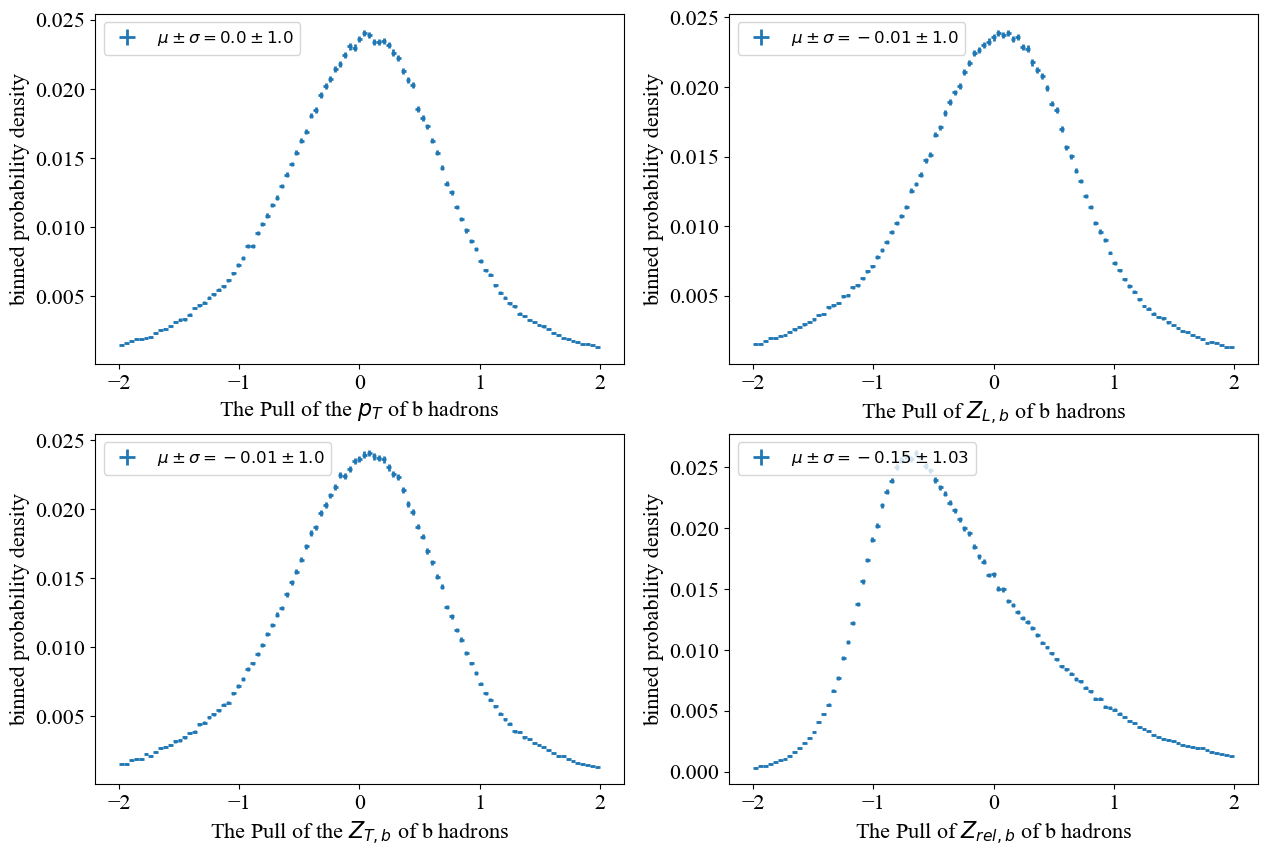

In [158]:
Figure, axes = plt.subplots(2,2, figsize = (15,10))
l7 = binneddensitysub(Pull_pt, fixedbinning(-2,2,100), ax = axes[0,0], xlabel = "The Pull of the $p_T$ of b hadrons",)
l8 = binneddensitysub(Pull_ptfraction, fixedbinning(-2,2,100), ax = axes[1,0], xlabel = "The Pull of the $Z_{T,b}$ of b hadrons")
l9 = binneddensitysub(Pull_projection, fixedbinning(-2,2,100), ax = axes[0,1], xlabel = "The Pull of $Z_{L,b}$ of b hadrons")
l10 = binneddensitysub(Pull_projectiont, fixedbinning(-2,2,100), ax = axes[1,1], xlabel = "The Pull of $Z_{rel,b}$ of b hadrons")
axes[0,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean,2)} \pm {round(Pull_pt_std,2)}$"],loc = "upper left", fontsize = 12)
axes[1,0].legend([f"$\mu \pm \sigma = {round(Pull_pt_mean_fraction,2)} \pm {round(Pull_pt_std_fraction,2)}$"], loc = "upper left", fontsize = 12)
axes[0,1].legend([f"$\mu \pm \sigma = {round(Pull_projection_mean,2)} \pm {round(Pull_projection_std,2)}$"], loc = "upper left", fontsize = 12)
axes[1,1].legend([f"$\mu \pm \sigma = {round(Pull_projectiont_mean,2)} \pm {round(Pull_projectiont_std,2)}$"], loc = "upper left", fontsize = 12)
Figure.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJets26.pdf", dpi = 500)

In [180]:
particles_input_scaled_test = np.load("Test_particles_input_scaled.npy")
re_b_jets_input_scaled_test = np.load("Test_re_b_jets_input_scaled.npy")
bhads_target_test = np.load("Test_bhads_targets.npy")
onehot_test = np.load("Test_onehot.npy")

In [181]:
particles_input_scaled_test.shape

(1287909, 96, 17)

In [182]:
particles_input_scaled_test = particles_input_scaled_test[500000:]
re_b_jets_input_scaled_test = re_b_jets_input_scaled_test[500000:]
bhads_target_test = bhads_target_test[500000:]
onehot_test = onehot_test[500000:]

In [183]:
particles_input_scaled_test.shape

(787909, 96, 17)

In [186]:
# Builds the deep neural network
track_layers = [64 for x in range(2)]
jet_layers = [100 for x in range(3)]
b_jets_layers = [64 for x in range(2)]

track_layers = [np.shape(particles_input_scaled_test)[2]]+track_layers
print(track_layers)
print(np.shape(onehot_test)[1])
#Initializers the optimizer used for training the network
optimizer = tf.keras.optimizers.Nadam(LR)

#Build a DeepSets Projection Neural Network
DeepSetProjector2 = DeepSetsProjection(track_layers=track_layers, b_jet_layers= b_jets_layers, jet_layers=jet_layers, n_targets=np.shape(bhads_target_test)[1], n_targets_classification= np.shape(onehot_test)[1], regularizer_strength= 1e-4, n_features=np.shape(re_b_jets_input_scaled_test)[1], Dropout_rate=0.1)

from DeepSetNeuralNetArchitecture import LogNormal_Loss_Function
from HffragDeepSetsProjection import Multivariate_Gaussian_Negative_Likelihood_Loss_Curve
from HffragDeepSetsProjectionMultivariate import weighted_categorical_crossentropy
DeepSetProjector2.compile(
 optimizer = optimizer,
 loss = {"MultivariateLoss": Multivariate_Gaussian_Negative_Likelihood_Loss_Curve, "MassOutput":tf.keras.losses.categorical_crossentropy},
 metrics = [Mean_Squared_Error]   
)

path = "/home/physics/phujdj/WeightsSaved/MultivariateParticleDeepSetsReconstructedJetsFinal.ckpt"
checkpoint = os.path.dirname(path)
latest_DeepNet = tf.train.latest_checkpoint(checkpoint)

DeepSetProjector2.load_weights(latest_DeepNet)
#Evaluate the entire performance of the model
loss = DeepSetProjector2.evaluate((particles_input_scaled_test,re_b_jets_input_scaled_test),(bhads_target_test, onehot_test),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

[17, 64, 64]
3
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Instructions for updating:
Use fn_output_signature instead
24623/24623 - 116s - loss: 64644.5703 - MultivariateLoss_loss: 64642.1211 - MassOutput_loss: 1.0236 - MultivariateLoss_Mean_Squared_Error: 0.0484 - MassOutput_Mean_Squared_Error: 0.2073 - 116s/epoch - 5ms/step
The Loaded DeepNet has loss:  [64644.5703125, 64642.12109375, 1.0236101150512695, 0.04842665046453476, 0.20729003846645355]


In [187]:
particles_input_scaled = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Final_particles_input_scaled.npy")
re_b_jets_input_scaled = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Final_re_b_jets_input_scaled.npy")
bhads_targets = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Final_bhads_targets.npy")
onehot = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/Final_onehot.npy")


In [188]:
loss = DeepSetProjector2.evaluate((particles_input_scaled,re_b_jets_input_scaled),(bhads_targets, onehot),verbose = 2)
print("The Loaded DeepNet has loss: ", loss)

15026/15026 - 71s - loss: -7.2709e+01 - MultivariateLoss_loss: -7.5179e+01 - MassOutput_loss: 1.0048 - MultivariateLoss_Mean_Squared_Error: 0.0148 - MassOutput_Mean_Squared_Error: 0.2041 - 71s/epoch - 5ms/step
The Loaded DeepNet has loss:  [-72.70925903320312, -75.17925262451172, 1.0048398971557617, 0.014781899750232697, 0.2041415572166443]


In [189]:
history = pd.read_csv('/home/physics/phujdj/DeepLearningParticlePhysics/ResNetDeepSetFinalNew.csv')

In [193]:
history

,Unnamed: 0,loss,MultivariateLoss_loss,MassOutput_loss,MultivariateLoss_Mean_Squared_Error,MassOutput_Mean_Squared_Error,val_loss,val_MultivariateLoss_loss,val_MassOutput_loss,val_MultivariateLoss_Mean_Squared_Error,val_MassOutput_Mean_Squared_Error,lr
0,0,-1.942720,-17.699219,1.010428,0.429478,0.205257,-16.739643,-30.091064,1.006981,0.298606,0.204653,0.000300
1,1,-24.353052,-36.031025,1.008004,0.106408,0.204829,-26.134958,-36.582066,1.007963,0.025082,0.205013,0.000300
2,2,-31.649342,-41.384953,1.007652,0.023137,0.204755,-34.035480,-43.182343,1.005646,0.020669,0.204353,0.000300
3,3,-34.596664,-43.308601,1.007321,0.020780,0.204673,-33.540993,-41.859772,1.005581,0.019145,0.204357,0.000300
4,4,-36.501961,-44.500458,1.007155,0.019677,0.204635,-34.067562,-41.766808,1.005251,0.018565,0.204269,0.000300
...,...,...,...,...,...,...,...,...,...,...,...,...
793,793,-72.867981,-75.338539,1.004395,0.014986,0.204045,-72.305992,-74.778137,1.005882,0.014329,0.204371,0.000001
794,794,-72.868576,-75.339172,1.004399,0.014986,0.204045,-72.197830,-74.670052,1.005886,0.014330,0.204370,0.000001
795,795,-72.870064,-75.340691,1.004400,0.014986,0.204045,-72.120255,-74.592537,1.005882,0.014330,0.204370,0.000001
796,796,-72.872353,-75.343208,1.004393,0.014987,0.204044,-72.338966,-74.811295,1.005888,0.014329,0.204371,0.000001


<AxesSubplot:>

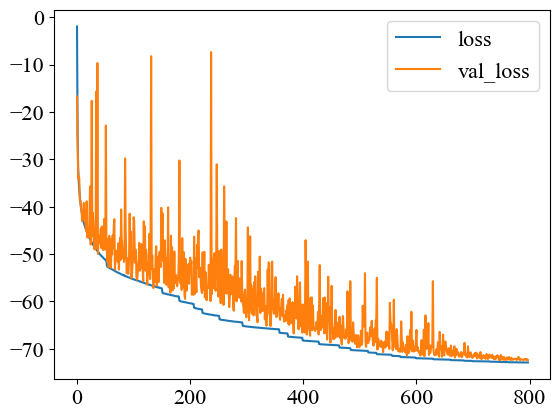

In [194]:
(history.loc[:, ["loss","val_loss"]]).plot()

In [195]:
Predictions_Mass = np.load("/home/physics/phujdj/DeepLearningParticlePhysics/FinalPredictions_Mass.npy")

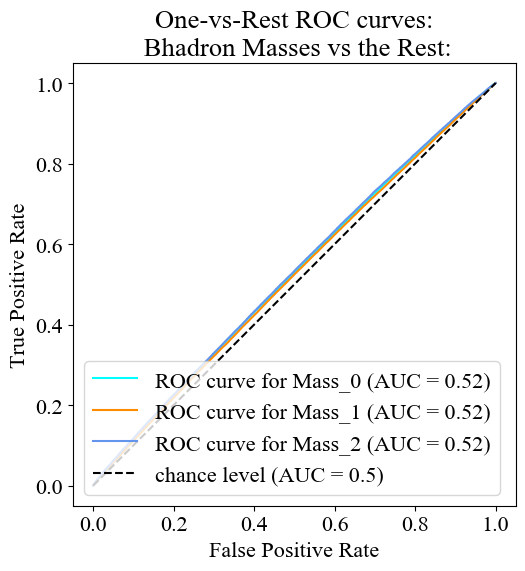

In [200]:
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
target_names = ["Mass_0", "Mass_1", "Mass_2"]
fig, ax = plt.subplots(figsize = (6,6))
colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for class_id, colors in zip(range(3), colors):
    RocCurveDisplay.from_predictions(
        onehot[:,class_id],
        Predictions_Mass[:, class_id],
        name = f"ROC curve for {target_names[class_id]}",
        color = colors,
        ax = ax,
    )
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves:\n Bhadron Masses vs the Rest:")
plt.legend()
plt.tight_layout()
plt.savefig("/home/physics/phujdj/DeepLearningParticlePhysics/DeepSetsJetsROC.pdf", dpi = 500)
plt.show()